# Explaining cortical thickness development: Single-subject data

Note: Because of data protection policies, ABCD and IMAGEN data is not included in this repository and all code that display subject-level data are commented out. Please see the "_getData" notebooks for further information.

In [1]:
import sys
import os
from os.path import join
import copy
import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib import pyplot as plt
import matplotlib as mpl
from pingouin import ancova, pairwise_tests
import seaborn as sns
from scipy.stats import spearmanr
from IPython.display import display
from tqdm.auto import tqdm 
from joblib import Parallel, delayed

# custom functions
from scripts.templates import get_destrieux
from scripts.utils import alt_idps, alt_preds, na, replace, sel_cols, p_to_ast
from scripts.plots_brain import get_parc_gifti, plot_surf_ax
from scripts.plots import plot_raincloud

# working path
wd = os.path.dirname(os.path.realpath("__file__"))
print("Working directory:", wd)

# JuSpyce
sys.path.append(os.path.dirname(join(wd, "scripts", "juspyce")))
from juspyce.api import JuSpyce
from juspyce.stats import corr, residuals, mc_correction
from juspyce.nulls import generate_null_maps

# predictor data path
predictor_dir = join(wd, "data_predictors")

# plot directory
plot_dir = join(wd, "plots", "abcd-imgn")

# ABCD directory
abcdimgn_dir = join(wd, "data_ABCD-IMGN")

# rerun dominance analyses
rerun_dominance = False

# number of permutations
n_perm = 1000

Working directory: /Users/llotter/projects/ntct


## Get data

### Get ABCD & IMAGEN data

In [2]:
abcd = pd.read_feather(join(abcdimgn_dir, "abcd_pred.ftr")).set_index(["idx_id", "idx_tp"])
abcd = abcd[abcd.both_tp==True]

imgn = pd.read_feather(join(abcdimgn_dir, "imgn_pred.ftr")).set_index(["idx_id", "idx_tp"])
imgn = imgn[imgn.tp_one!=True]

dss = ["abcd"] + ["imgn"]*3

tps = ["T0", "T2", "T0", "T5", "T8"]
ds_tps = [("abcd", "T0"), ("abcd", "T2"), ("imgn", "T0"), ("imgn", "T5"), ("imgn", "T8")] 
n_tp = len(ds_tps)

tss = ["T0T2", "T0T8", "T0T5", "T5T8"]
ds_tss = [("abcd", "T0T2"), ("imgn", "T0T8"), ("imgn", "T0T5"), ("imgn", "T5T8")]
n_ts = len(tss)

tss_age = [(10,12), (14,22), (14,19), (19,22)]
tss_age_exact = \
    [(np.round(df.loc[(na(), ts[:2]), "age"].mean(), 2), 
      np.round(df.loc[(na(), ts[2:]), "age"].mean(), 2)) for df, (_, ts) in zip([abcd, imgn, imgn, imgn], ds_tss)]
tss_age_mean = [np.round(np.mean(a),2) for a in tss_age_exact]
    
print(tss_age_exact)
print(tss_age_mean)

[(9.91, 11.96), (14.44, 22.55), (14.44, 19.0), (19.0, 22.55)]
[10.94, 18.5, 16.72, 20.78]


### Get predictor data

In [3]:
# all predictors
predictors_destrieux = pd.read_csv(join(predictor_dir, 'data_factors_destrieux.csv'), index_col=0)
predictors = list(predictors_destrieux.columns)
print("All predictors:\n", predictors)

# single-subjects analyses: significant (uncorrected) in dominance analysis and relevant
# for the age span of ABCD/IMGN (defined as rounded min and max age)
temp = JuSpyce.from_pickle(
    join(wd, "data_rutherford", "juspyce_ct_dominance_fm_500_5.pkl.gz"), verbose=False) \
        .p_predictions["dominance_total"]
        
predictors_abcd = (temp < 0.05).loc[[f"Δ({i},{i+5})" for i in \
    range(int(abcd.age.round(0).min()), int(abcd.age.round(0).max()+1))]].any()
predictors_abcd = predictors_abcd[predictors_abcd==True].index.to_list()

predictors_imgn = (temp < 0.05).loc[[f"Δ({i},{i+5})" for i in \
    range(int(imgn.age.round(0).min()), int(imgn.age.round(0).max()+1))]].any()
predictors_imgn = predictors_imgn[predictors_imgn==True].index.to_list()

predictors_both = [p for p in predictors if (p in predictors_abcd) | (p in predictors_imgn)]

# colors for plotting
c_full_model = np.array([0.8,0.8,0.8,1])
c_predictors_both = get_cmap("tab10")([1, 3, 4, 5, 6, 7, 8])

print(f"Single-subject predictors: \nABCD: {predictors_abcd}, \nIMGN: {predictors_imgn}, "
      f"\nboth: {predictors_both}")

All predictors:
 ['ni1-SV2A-M1-mGluR5-5HT6-CB1-GABAa-HDAC', 'ni2-5HT2a-5HT4-5HT1a-5HTT', 'ni3-FDOPA-DAT-D1-NMDA', 'ni4-GI-5HT1b-MU-A4B2', 'ni5-VAChT-NET', 'ni6-CBF-CMRglu', 'ni7-COX1', 'ni8-H3', 'ni9-D2', 'ni10-TSPO', 'ce1-Ex7-In4-Ex5-Ex4-In1', 'ce2-Oligo-Endo', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce6-Ex8-Ex6', 'ce7-In7-Ex3', 'ce8-In5', 'ce9-In8', 'ce10-Ex1', 'mr1-myelin']
Single-subject predictors: 
ABCD: ['ni4-GI-5HT1b-MU-A4B2', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8'], 
IMGN: ['ni4-GI-5HT1b-MU-A4B2', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8'], 
both: ['ni4-GI-5HT1b-MU-A4B2', 'ni6-CBF-CMRglu', 'ni9-D2', 'ce3-Micro-OPC', 'ce4-In3-In2-Astro', 'ce5-In6-Ex2', 'ce9-In8']


### Get IDPs and parcellation

In [4]:
parc_destrieux, destrieux_idps = get_destrieux()

## CT development

In [5]:
temp = dict()

for data, name in zip([abcd[abcd.both_tp==True], 
                       imgn[imgn.tp_T0T8==True],
                       imgn[imgn.tp_T0T5==True],
                       imgn[imgn.tp_T5T8==True]],
                      ["abcd_T0T2", "imgn_T0T8", "imgn_T0T5", "imgn_T5T8"]):
    
    subs = list(data.id.unique())
    tps = data.tp.unique().tolist()
    print(name, tps)
    if len(tps) != 2:
        print("Something wrong!")
        break
    temp1 = data.loc[(subs, tps[0]), :].copy()
    temp2 = data.loc[(subs, tps[1]), :].copy()

    delta_dict = dict()
    for idp in ["EstimatedTotalIntraCranialVol"] + destrieux_idps:
        
        # get CT data
        ct_T0 = temp1[idp+"-rescaled"].to_numpy()
        ct_T2 = temp2[idp+"-rescaled"].to_numpy()
        ct_T0_pred = temp1[idp+"-pred50"].to_numpy()
        ct_T2_pred = temp2[idp+"-pred50"].to_numpy()
        ct_T0_orig = temp1[idp].to_numpy()
        ct_T2_orig = temp2[idp].to_numpy()
        # calculate relative change
        ct_delta = (ct_T2 - ct_T0) / ct_T0
        ct_delta_pred = (ct_T2_pred - ct_T0_pred) / ct_T0_pred
        ct_delta_orig = (ct_T2_orig - ct_T0_orig) / ct_T0_orig
        
        # get Z data
        z_T0 = temp1[idp+"-z"].to_numpy()
        z_T2 = temp2[idp+"-z"].to_numpy()
        # calculate change in deviation z scores
        z_delta = z_T2 - z_T0
        
        # save
        delta_dict[idp+"-delta"] = ct_delta
        delta_dict[idp+"-delta_orig"] = ct_delta_orig
        delta_dict[idp+"-delta_pred"] = ct_delta_pred
        delta_dict[idp+"-z_delta"] = z_delta
        
        # correct CT and Z values for ICV
        if idp != "EstimatedTotalIntraCranialVol":
            
            ct_T0_tiv = residuals(temp1["EstimatedTotalIntraCranialVol-rescaled"].to_numpy(), ct_T0, decenter=True) 
            ct_T2_tiv = residuals(temp2["EstimatedTotalIntraCranialVol-rescaled"].to_numpy(), ct_T2, decenter=True) 
            ct_delta_tiv = (ct_T2_tiv - ct_T0_tiv) / ct_T0_tiv
            
            delta_dict[idp+"-delta_tiv"] = ct_delta_tiv

    # dict to df, construct index to match on "second-tp" subjects
    delta_df = pd.DataFrame(delta_dict, index=subs, dtype=np.float32)
    delta_df = delta_df.set_index(pd.Series([name[-2:]]*len(subs)), append=True)
    delta_df.index.names = ["idx_id", "idx_tp"]

    temp[name] = delta_df

# merge to pheno dataframes
abcd = abcd.merge(temp["abcd_T0T2"], on=["idx_id", "idx_tp"], how="left")
imgn_T0T8 = imgn.merge(temp["imgn_T0T8"], on=["idx_id", "idx_tp"], how="left")[imgn.tp_T0T8==True]
imgn_T0T5 = imgn.merge(temp["imgn_T0T5"], on=["idx_id", "idx_tp"], how="left")[imgn.tp_T0T5==True]
imgn_T5T8 = imgn.merge(temp["imgn_T5T8"], on=["idx_id", "idx_tp"], how="left")[imgn.tp_T5T8==True]

# new dataframe with ct-derivatives of all subjects across studies
ct_cols = ["id", "td", "site", "age", "sex"] + temp["abcd_T0T2"].columns.to_list()
data_delta = pd.concat([
    abcd.loc[(na(), "T2"), ct_cols].assign(ds="abcd", ts="T0T2").set_index(["ds", "id", "ts"], drop=False),
    imgn_T0T8.loc[(na(), "T8"), ct_cols].assign(ds="imgn", ts="T0T8").set_index(["ds", "id", "ts"], drop=False),
    imgn_T0T5.loc[(na(), "T5"), ct_cols].assign(ds="imgn", ts="T0T5").set_index(["ds", "id", "ts"], drop=False),
    imgn_T5T8.loc[(na(), "T8"), ct_cols].assign(ds="imgn", ts="T5T8").set_index(["ds", "id", "ts"], drop=False),
])
#display(data_delta)

# new dataframe with cross-sectional data for sanity checks (only subjects that have longitudinal data)
ct_cols = ["id", "tp", "td", "site", "age", "sex"] + [c for c in abcd.columns if ("_thickness" in c) & ("delta" not in c)]
data_cross = pd.concat([
    abcd.loc[(data_delta[data_delta.ds=="abcd"].id.unique(), na()), ct_cols].assign(ds="abcd").set_index(["ds", "id", "tp"], drop=False),
    imgn.loc[(data_delta[data_delta.ds=="imgn"].id.unique(), na()), ct_cols].assign(ds="imgn").set_index(["ds", "id", "tp"], drop=False),
])
#display(data_cross)

abcd_T0T2 ['T0', 'T2']
imgn_T0T8 ['T0', 'T8']
imgn_T0T5 ['T0', 'T5']
imgn_T5T8 ['T5', 'T8']


### Plot mean brains

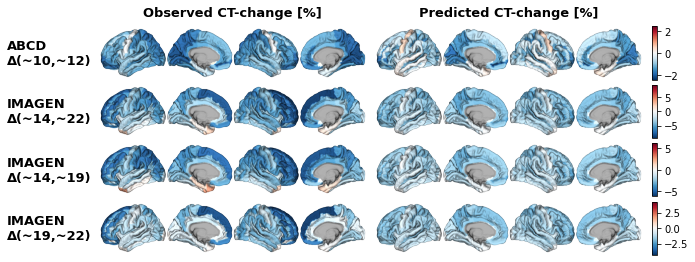

In [6]:
fig, axes = plt.subplots(4,3, figsize=(10,4.2), gridspec_kw=dict(hspace=0.1, wspace=0.05, width_ratios=(1,1,0.02)))

for r, ds_ts, ts_age in zip(range(4), ds_tss, tss_age):
    ds = ds_ts[0]
    ts = ds_ts[1]
    temp1 = data_delta.loc[(data_delta.ts==ts), alt_idps("-delta", destrieux_idps)].mean("rows") * 100    
    temp2 = data_delta.loc[(data_delta.ts==ts), alt_idps("-delta_pred", destrieux_idps)].mean("rows") * 100
    lim = np.max([temp1.abs().max(), temp2.abs().max()])
    
    for c, data in enumerate([temp1, temp2]):
        lh, rh = get_parc_gifti(data)
        plot_surf_ax(ax=axes[r,c], fig=fig, lh=lh, rh=rh, c="RdBu_r", c_lims=(-lim, lim))
        norm = mpl.colors.Normalize(-lim, lim)
        sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
        sm.set_array([])
        cb = plt.colorbar(sm, cax=axes[r,2])
        
    axes[r,0].annotate(
        f"{'ABCD' if ds=='abcd' else 'IMAGEN'}\nΔ(~{ts_age[0]},~{ts_age[1]})", xy=(-0.35,0.5), 
        va="center", xycoords="axes fraction", weight="semibold", size=13
    )
[axes[0,c].set_title(l+" CT-change [%]", weight="semibold", pad=10, size=13) for c, l in enumerate(["Observed", "Predicted"])]

fig.savefig(join(plot_dir, "dev_ct_deltabrains.png"), dpi=250, bbox_inches="tight")

### Look at site effects

#### Cross-sectional

In [7]:
site_eff_bl = dict()
for ds, tp in ds_tps:
    
    temp = data_cross.loc[(ds, na(), tp), :]
    
    temp_dict = dict()
    for idp in destrieux_idps:
        for suff, name in zip(["", "-rescaled", "-z"], ["", "(site-corrected)", "(deviation Z)"]):
            anc = ancova(
                data=temp,
                dv=idp + suff,
                between="site",
                covar=["age", "sex"]
            )
            temp_anc = anc.iloc[0,1:]
            temp_anc["df"] = (anc.DF.values[0], anc.DF.values[-1])
            temp_anc["F"] = temp_anc["F"].round(2)
            temp_anc["np2"] = temp_anc["np2"].round(2)
            temp_anc["p-unc"] = "< 0.001" if temp_anc["p-unc"] < 0.001 else f"{temp_anc['p-unc']:.03f}"
            temp_anc = temp_anc[["F", "df", "p-unc", "np2"]]
            temp_dict[f"{idp.replace('_thickness', '')} {name}"] = temp_anc
       
    site_eff_bl[("ABCD" if ds=="abcd" else "IMAGEN", tp)] = pd.DataFrame.from_dict(temp_dict, orient="index")
    
site_eff_bl = pd.concat(site_eff_bl, axis=1)
site_eff_bl.to_csv(join(abcdimgn_dir, "site_effects_cross.csv"))
site_eff_bl

ABCD                             \
                                              T0                              
                                               F          df    p-unc   np2   
lh_G&S_frontomargin                        15.47  (20, 6766)  < 0.001  0.04   
lh_G&S_frontomargin (site-corrected)       25.51  (20, 6766)  < 0.001  0.07   
lh_G&S_frontomargin (deviation Z)          24.46  (20, 6766)  < 0.001  0.07   
lh_G&S_occipital_inf                       13.25  (20, 6766)  < 0.001  0.04   
lh_G&S_occipital_inf (site-corrected)      22.20  (20, 6766)  < 0.001  0.06   
...                                          ...         ...      ...   ...   
rh_S_temporal_sup (site-corrected)         25.60  (20, 6766)  < 0.001  0.07   
rh_S_temporal_sup (deviation Z)            27.22  (20, 6766)  < 0.001  0.07   
rh_S_temporal_transverse                    1.95  (20, 6766)    0.007  0.01   
rh_S_temporal_transverse (site-corrected)  20.87  (20, 6766)  < 0.001  0.06   
rh_S_temporal_transverse (deviation Z)     16.05  (20, 6766)  < 0.001  0.05   

                                                                             \
                                              T2                              
                                               F          df    p-unc   np2   
lh_G&S_frontomargin                        15.17  (20, 6766)  < 0.001  0.04   
lh_G&S_frontomargin (site-corrected)       22.89  (20, 6766)  < 0.001  0.06   
lh_G&S_frontomargin (deviation Z)          23.33  (20, 6766)  < 0.001  0.06   
lh_G&S_occipital_inf                       11.55  (20, 6766)  < 0.001  0.03   
lh_G&S_occipital_inf (site-corrected)      28.11  (20, 6766)  < 0.001  0.08   
...                                          ...         ...      ...   ...   
rh_S_temporal_sup (site-corrected)         25.91  (20, 6766)  < 0.001  0.07   
rh_S_temporal_sup (deviation Z)            27.64  (20, 6766)  < 0.001  0.08   
rh_S_temporal_transverse                    1.43  (20, 6766)    0.096  0.00   
rh_S_temporal_transverse (site-corrected)  21.36  (20, 6766)  < 0.001  0.06   
rh_S_temporal_transverse (deviation Z)     15.95  (20, 6766)  < 0.001  0.05   

                                          IMAGEN                            \
                                              T0                             
                                               F         df    p-unc   np2   
lh_G&S_frontomargin                        12.20  (7, 1130)  < 0.001  0.07   
lh_G&S_frontomargin (site-corrected)       22.89  (7, 1130)  < 0.001  0.12   
lh_G&S_frontomargin (deviation Z)          24.02  (7, 1130)  < 0.001  0.13   
lh_G&S_occipital_inf                        6.81  (7, 1130)  < 0.001  0.04   
lh_G&S_occipital_inf (site-corrected)       7.40  (7, 1130)  < 0.001  0.04   
...                                          ...        ...      ...   ...   
rh_S_temporal_sup (site-corrected)          8.26  (7, 1130)  < 0.001  0.05   
rh_S_temporal_sup (deviation Z)             8.70  (7, 1130)  < 0.001  0.05   
rh_S_temporal_transverse                    2.57  (7, 1130)    0.012  0.02   
rh_S_temporal_transverse (site-corrected)   6.10  (7, 1130)  < 0.001  0.04   
rh_S_temporal_transverse (deviation Z)      5.24  (7, 1130)  < 0.001  0.03   

                                                                            \
                                              T5                             
                                               F         df    p-unc   np2   
lh_G&S_frontomargin                        44.49  (7, 1114)  < 0.001  0.22   
lh_G&S_frontomargin (site-corrected)       57.35  (7, 1114)  < 0.001  0.26   
lh_G&S_frontomargin (deviation Z)          62.20  (7, 1114)  < 0.001  0.28   
lh_G&S_occipital_inf                       15.33  (7, 1114)  < 0.001  0.09   
lh_G&S_occipital_inf (site-corrected)      20.16  (7, 1114)  < 0.001  0.11   
...                                          ...        ...      ...   ...   
rh_S_temporal_sup (site-corrected) 

#### Longitudinal

In [8]:
site_eff_bl = dict()
for ds, ts in ds_tss:
    
    temp = data_delta.loc[(ds, na(), ts), :].copy()
    df = abcd if ds=="abcd" else imgn
    temp["age_diff"] = df.loc[(temp.index.get_level_values("id"), ts[2:]), "age"].values - \
        df.loc[(temp.index.get_level_values("id"), ts[:2]), "age"].values
    
    temp_dict = dict()
    for idp in destrieux_idps:
        for suff, name in zip(["-delta_orig", "-delta", "-z_delta"], ["", "(site-corrected)", "(deviation Z)"]):
            anc = ancova(
                data=temp,
                dv=idp + suff,
                between="site",
                covar=["age_diff", "sex"]
            )
            temp_anc = anc.iloc[0,1:]
            temp_anc["df"] = (anc.DF.values[0], anc.DF.values[-1])
            temp_anc["F"] = temp_anc["F"].round(2)
            temp_anc["np2"] = temp_anc["np2"].round(2)
            temp_anc["p-unc"] = "< 0.001" if temp_anc["p-unc"] < 0.001 else f"{temp_anc['p-unc']:.03f}"
            temp_anc = temp_anc[["F", "df", "p-unc", "np2"]]
            temp_dict[f"{idp.replace('_thickness', '')} {name}"] = temp_anc
       
    site_eff_bl[("ABCD" if ds=="abcd" else "IMAGEN", f"{ts[:2]}-{ts[2:]}")] = pd.DataFrame.from_dict(temp_dict, orient="index")
    
site_eff_bl = pd.concat(site_eff_bl, axis=1)
site_eff_bl.to_csv(join(abcdimgn_dir, "site_effects_delta.csv"))
site_eff_bl

ABCD                             \
                                          T0-T2                              
                                              F          df    p-unc   np2   
lh_G&S_frontomargin                        4.38  (20, 6766)  < 0.001  0.01   
lh_G&S_frontomargin (site-corrected)       4.48  (20, 6766)  < 0.001  0.01   
lh_G&S_frontomargin (deviation Z)          3.43  (20, 6766)  < 0.001  0.01   
lh_G&S_occipital_inf                       4.86  (20, 6766)  < 0.001  0.01   
lh_G&S_occipital_inf (site-corrected)      5.90  (20, 6766)  < 0.001  0.02   
...                                         ...         ...      ...   ...   
rh_S_temporal_sup (site-corrected)         2.27  (20, 6766)    0.001  0.01   
rh_S_temporal_sup (deviation Z)            1.79  (20, 6766)    0.016  0.01   
rh_S_temporal_transverse                   1.97  (20, 6766)    0.006  0.01   
rh_S_temporal_transverse (site-corrected)  2.01  (20, 6766)    0.005  0.01   
rh_S_temporal_transverse (deviation Z)     1.97  (20, 6766)    0.006  0.01   

                                          IMAGEN                           \
                                           T0-T8                            
                                               F        df    p-unc   np2   
lh_G&S_frontomargin                        85.83  (7, 832)  < 0.001  0.42   
lh_G&S_frontomargin (site-corrected)       88.05  (7, 832)  < 0.001  0.43   
lh_G&S_frontomargin (deviation Z)          86.64  (7, 832)  < 0.001  0.42   
lh_G&S_occipital_inf                       28.68  (7, 832)  < 0.001  0.19   
lh_G&S_occipital_inf (site-corrected)      32.80  (7, 832)  < 0.001  0.22   
...                                          ...       ...      ...   ...   
rh_S_temporal_sup (site-corrected)         25.34  (7, 832)  < 0.001  0.18   
rh_S_temporal_sup (deviation Z)            26.20  (7, 832)  < 0.001  0.18   
rh_S_temporal_transverse                    2.78  (7, 832)    0.007  0.02   
rh_S_temporal_transverse (site-corrected)   3.27  (7, 832)    0.002  0.03   
rh_S_temporal_transverse (deviation Z)      2.58  (7, 832)    0.012  0.02   

                                                                           \
                                           T0-T5                            
                                               F        df    p-unc   np2   
lh_G&S_frontomargin                        24.78  (7, 997)  < 0.001  0.15   
lh_G&S_frontomargin (site-corrected)       25.61  (7, 997)  < 0.001  0.15   
lh_G&S_frontomargin (deviation Z)          19.74  (7, 997)  < 0.001  0.12   
lh_G&S_occipital_inf                       20.73  (7, 997)  < 0.001  0.13   
lh_G&S_occipital_inf (site-corrected)      21.37  (7, 997)  < 0.001  0.13   
...                                          ...       ...      ...   ...   
rh_S_temporal_sup (site-corrected)         22.31  (7, 997)  < 0.001  0.14   
rh_S_temporal_sup (deviation Z)            21.74  (7, 997)  < 0.001  0.13   
rh_S_temporal_transverse                    5.67  (7, 997)  < 0.001  0.04   
rh_S_temporal_transverse (site-corrected)   6.09  (7, 997)  < 0.001  0.04   
rh_S_temporal_transverse (deviation Z)      5.64  (7, 997)  < 0.001  0.04   

                                                                           
                                           T5-T8                           
                                               F        df    p-unc   np2  
lh_G&S_frontomargin                        63.45  (7, 816)  < 0.001  0.35  
lh_G&S_frontomargin (site-corrected)       62.83  (7, 816)  < 0.001  0.35  
lh_G&S_frontomargin (deviation Z)          77.20  (7, 816)  < 0.001  0.40  
lh_G&S_occipital_inf                       31.61  (7, 816)  < 0.001  0.21  
lh_G&S_occipital_inf (site-corrected)      35.36  (7, 816)  < 0.001  0.23  
...                                          ...       ...      ...   ...  
rh_S_temporal_sup (site-corrected)         17.25  (7, 816)  < 0.001  0.13  
rh_S_temporal_sup (deviation Z) 

## Association analyses

### JuSpyce wrapper functions

In [6]:
# cross-sectional: spearman
def run_juspyce_spearman(y, pred, save_path=None):
    
    juspyce_spearman = JuSpyce(
        x=predictors_destrieux[pred].T,
        y=y,
        data_space="fsaverage",
        parcellation=parc_destrieux,
        parcellation_space="fsaverage",
        parcellation_density="10k",
        standardize=False,
        drop_nan=False,
        n_proc=-1
    ).fit()
    
    juspyce_spearman.predict(method="spearman", r_to_z=True)
    
    if save_path is not None:
        juspyce_spearman.to_pickle(save_path)
        
    return juspyce_spearman

# longitudinal: dominance analysis
def run_juspyce_dominance(y, pred, save_path=None):
    
    juspyce_dominance = JuSpyce(
        x=predictors_destrieux[pred].T,
        y=y,
        data_space="fsaverage",
        parcellation=parc_destrieux,
        parcellation_space="fsaverage",
        parcellation_density="10k",
        standardize=False,
        drop_nan=False,
        n_proc=-1
    ).fit()
    
    juspyce_dominance.predict("mlr", adjust_r2=True, mlr_individual=False, verbose=True)
    juspyce_dominance.predict("dominance", adjust_r2=True, verbose=True) # non-adjusted R2?
    juspyce_dominance.predict(method="spearman", r_to_z=True)
    
    if save_path is not None:
        juspyce_dominance.to_pickle(save_path, save_nulls=False)
        
    return juspyce_dominance

# longitudinal: dominance analysis with permutation per dataset/timespan
def run_juspyce_dominance_perm(y, pred, n_perm=n_perm, dist_mat=None):
    
    nulls = None
    sig = dict()
    for ds, ts in ds_tss:
        
        juspyce_dominance = JuSpyce(
            x=predictors_destrieux[pred].T,
            y=y.reset_index().query("(ds==@ds) & (ts==@ts)")[destrieux_idps],
            data_space="fsaverage",
            parcellation=parc_destrieux,
            parcellation_space="fsaverage",
            parcellation_density="10k",
            standardize=False,
            drop_nan=False,
            n_proc=-1
        ).fit()
        
        juspyce_dominance.permute_maps(method="dominance", adjust_r2=True, p_from_average_y=True,
                                       null_maps=nulls, dist_mat=dist_mat, n_perm=n_perm, seed=42)
        juspyce_dominance.correct_p("predictions")
        sig[(ds, ts)] = juspyce_dominance.p_predictions
        nulls = juspyce_dominance.nulls["null_maps"].copy()
    
    return pd.concat(
        [sig[(ds, ts)]["dominance_full_r2"].join(sig[(ds, ts)]["dominance_total"]) \
            for ds, ts in ds_tss]) \
            .rename(columns={"dominance_full_r2":"full_r2"}) \
            .assign(ds=["abcd"]*1 + ["imgn"]*3, ts=tss).set_index(["ds", "ts"])
    

### Cross-sectional: Spearman correlations

In [7]:
temp = data_cross[[c for c in data_cross.columns if "_thickness" in c]]

data_cross_long = pd.concat([
    temp[alt_idps("-rescaled", destrieux_idps)] \
        .assign(analysis="rescaled").set_index("analysis", append=True) \
        .rename(columns=dict(zip(alt_idps("-rescaled", destrieux_idps), destrieux_idps))),
    temp[alt_idps("-pred50", destrieux_idps)] \
        .assign(analysis="pred").set_index("analysis", append=True) \
        .rename(columns=dict(zip(alt_idps("-pred50", destrieux_idps), destrieux_idps))),
    temp[destrieux_idps] \
        .assign(analysis="orig").set_index("analysis", append=True) 
])
#data_cross_long

In [8]:
juspyce_cross = run_juspyce_spearman(
    y=data_cross_long,
    pred=predictors,
    save_path=None # join(wd, "data", f"juspyce_abcd_ct_spearman.pkl.gz")
)

INFO:juspyce.api:Checking input data for x (should be, e.g., PET data):
INFO:juspyce.io:Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO:juspyce.api:Got 'x' data for 21 x 148 parcels.
INFO:juspyce.api:Checking input data for y (should be, e.g., subject data):
INFO:juspyce.io:Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
INFO:juspyce.api:Got 'y' data for 50403 x 148 parcels.


Predicting (spearman, -1 proc):   0%|          | 0/50403 [00:00<?, ?it/s]

### Longitudinal: Dominance analyses

In [9]:
data_delta_long = pd.concat([
    data_delta[alt_idps("-delta", destrieux_idps)] \
        .dropna(axis="index") \
        .assign(analysis="delta").set_index("analysis", append=True)
        .rename(columns=dict(zip(alt_idps("-delta", destrieux_idps), destrieux_idps))),
    data_delta[alt_idps("-delta_pred", destrieux_idps)] \
        .dropna(axis="index") \
        .assign(analysis="delta_pred").set_index("analysis", append=True)
        .rename(columns=dict(zip(alt_idps("-delta_pred", destrieux_idps), destrieux_idps))),
    data_delta[alt_idps("-delta_orig", destrieux_idps)] \
        .dropna(axis="index") \
        .assign(analysis="delta_orig").set_index("analysis", append=True)
        .rename(columns=dict(zip(alt_idps("-delta_orig", destrieux_idps), destrieux_idps))),
    data_delta[alt_idps("-delta_tiv", destrieux_idps)] \
        .dropna(axis="index") \
        .assign(analysis="delta_tiv").set_index("analysis", append=True)
        .rename(columns=dict(zip(alt_idps("-delta_tiv", destrieux_idps), destrieux_idps))),
    data_delta[alt_idps("-z_delta", destrieux_idps)] \
        .dropna(axis="index") \
        .assign(analysis="z_delta").set_index("analysis", append=True)
        .rename(columns=dict(zip(alt_idps("-z_delta", destrieux_idps), destrieux_idps)))
])

data_delta_long_sitemean = pd.concat([
    data_delta.loc[data_delta.ts==ds_ts[1], alt_idps("-delta", destrieux_idps) + ["site"]] \
        .dropna(axis="index")\
        .rename(columns=dict(zip(alt_idps("-delta", destrieux_idps), destrieux_idps))) \
        .groupby("site").mean() \
        .assign(ds=ds_ts[0], ts=ds_ts[1]).set_index(["ds", "ts"], append=True) \
        for ds_ts in ds_tss
])

data_delta_long_allmean = pd.concat([
    pd.DataFrame(data_delta_long.loc[(ds_ts[0], na(), ds_ts[1], "delta")].mean("index")).T \
        .assign(ds=ds_ts[0], ts=ds_ts[1]).set_index(["ds", "ts"]) \
        for ds_ts in ds_tss
])

In [10]:
# rerun dominance analyses
if rerun_dominance:

    # single subjects, different measures in long format dataframe
    juspyce_delta = run_juspyce_dominance(
        y=data_delta_long,
        pred=predictors_both,
        save_path=join(abcdimgn_dir, "juspyce_ct_dominance_subjects.pkl.gz")
    )

    # mean per site
    juspyce_delta_sitemean = run_juspyce_dominance(
        y=data_delta_long_sitemean,
        pred=predictors_both,
        save_path=join(abcdimgn_dir, "juspyce_ct_dominance_meansites.pkl.gz")
    )

    # mean per cohort
    juspyce_delta_allmean = run_juspyce_dominance(
        y=data_delta_long_allmean,
        pred=predictors_both,
        save_path=join(abcdimgn_dir, "juspyce_ct_dominance_meansubjects.pkl.gz")
    )
    
    # significance tests
    sig_delta = run_juspyce_dominance_perm(
        y=data_delta_long.loc[(na(),na(),na(), "delta"),:],
        pred=predictors_both,
    )
    sig_delta_pred = run_juspyce_dominance_perm(
        y=data_delta_long.loc[(na(),na(),na(), "delta_pred"),:],
        pred=predictors_both,
    )
    sig_delta_allmean = run_juspyce_dominance_perm(
        y=data_delta_long_allmean,
        pred=predictors_both,
    )
    sig_delta_sitemean = run_juspyce_dominance_perm(
        y=data_delta_long_sitemean,
        pred=predictors_both,
    )
    # save tables
    sig_delta.to_csv(join(abcdimgn_dir, "sig_delta.csv"))
    sig_delta_pred.to_csv(join(abcdimgn_dir, "sig_delta_pred.csv"))
    sig_delta_allmean.to_csv(join(abcdimgn_dir, "sig_delta_allmean.csv"))
    sig_delta_sitemean.to_csv(join(abcdimgn_dir, "sig_delta_sitemean.csv"))

# load from file 
else:
    juspyce_delta = JuSpyce.from_pickle(join(abcdimgn_dir, "juspyce_ct_dominance_subjects.pkl.gz"))
    juspyce_delta_sitemean = JuSpyce.from_pickle(join(abcdimgn_dir, "juspyce_ct_dominance_meansites.pkl.gz"))
    juspyce_delta_allmean = JuSpyce.from_pickle(join(abcdimgn_dir, "juspyce_ct_dominance_meansubjects.pkl.gz"))
    sig_delta = pd.read_csv(join(abcdimgn_dir, "sig_delta.csv"), index_col=[0,1])
    sig_delta_pred = pd.read_csv(join(abcdimgn_dir, "sig_delta_pred.csv"), index_col=[0,1])
    sig_delta_allmean = pd.read_csv(join(abcdimgn_dir, "sig_delta_allmean.csv"), index_col=[0,1])
    sig_delta_sitemean = pd.read_csv(join(abcdimgn_dir, "sig_delta_sitemean.csv"), index_col=[0,1])

INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/ntct/data_ABCD-IMGN/juspyce_ct_dominance_subjects.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/ntct/data_ABCD-IMGN/juspyce_ct_dominance_meansites.pkl.gz.
INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/ntct/data_ABCD-IMGN/juspyce_ct_dominance_meansubjects.pkl.gz.


### Longitudinal: Generalization

In [11]:
# get null maps

X_null, dist_mat = generate_null_maps(
    data=juspyce_delta.X, 
    parcellation=juspyce_delta.parc,
    parc_hemi=["L", "R"],
    parc_density="10k",
    seed=42,
    n_cores=8,
    n_nulls=n_perm
)

INFO:juspyce.nulls:Null map generation: Assuming n = 7 data vector(s) for n = 148 parcels.
INFO:juspyce.nulls:Loaded parcellation (parc_space = 'fsaverage', parc_hemi = ['L', 'R'], parc_density = '10k').
INFO:juspyce.nulls:Calculating distance matrix/matrices (geodesic).


Generating null maps (8 proc):   0%|          | 0/7 [00:00<?, ?it/s]

In [12]:
# calculate prediction performance

res_transpred, res_transpred_null = [], []

def calc_pred_corr(sub):
    
    rs, rs_null = dict(), dict()
    for k in ["r_pred", "r_obs", "r_transf"]: 
        rs[k], rs_null[k] = [], []
        
    y_pred = juspyce_delta.Y.loc[(ds, sub, ts, "delta_pred")].T.values
    y_obs = juspyce_delta.Y.loc[(ds, sub, ts, "delta")].T.values
    
    yhat_pred = np.dot(
        juspyce_delta.X.T.assign(intercept=1),
        params_pred.loc[(ds, sub, ts), :].iloc[0, :]
    )
    yhat_obs = np.dot(
        juspyce_delta.X.T.assign(intercept=1),
        params_obs.loc[(ds, sub, ts), :].iloc[0, :]
    )
        
    idx = ~np.isnan(yhat_pred)
    
    rs["r_pred"].append(corr(y_pred[idx], yhat_pred[idx], rank=False))
    rs["r_obs"].append(corr(y_obs[idx], yhat_obs[idx], rank=False))
    rs["r_transf"].append(corr(y_obs[idx], yhat_pred[idx], rank=False))
    
    for i in range(n_perm):
        
        X = np.c_[[X_null[pred][i, :] for pred in X_null] + [np.ones((148))]].T
        yhat_pred = np.dot(X, params_pred.loc[(ds, sub, ts), :].iloc[0, :])
        yhat_obs = np.dot(X, params_obs.loc[(ds, sub, ts), :].iloc[0, :])
        idx = ~np.isnan(yhat_pred)
        
        rs_null["r_pred"].append(corr(y_pred[idx], yhat_pred[idx], rank=False))
        rs_null["r_obs"].append(corr(y_obs[idx], yhat_obs[idx], rank=False))
        rs_null["r_transf"].append(corr(y_obs[idx], yhat_pred[idx], rank=False))
        
    return rs, rs_null
    

for ds, ts in ds_tss:
    
    subs = juspyce_delta.predictions["mlr_full_r2"].loc[(ds, na(), ts, "delta")].index.to_list()
    
    params_pred = pd.concat(
        [juspyce_delta.predictions["mlr_beta"].loc[(ds, subs, ts, "delta_pred")], 
         juspyce_delta.predictions["mlr_intercept"].loc[(ds, subs, ts, "delta_pred")]],
        axis=1
    )
    
    params_obs = pd.concat(
        [juspyce_delta.predictions["mlr_beta"].loc[(ds, subs, ts, "delta")], 
         juspyce_delta.predictions["mlr_intercept"].loc[(ds, subs, ts, "delta")]],
        axis=1
    )
    
    rs_list = Parallel(n_jobs=8)(delayed(calc_pred_corr)(sub) for sub in tqdm(subs)) 
    
    rs = pd.concat([pd.DataFrame(r[0]) for r in rs_list])
    rs.index = params_pred.index
    res_transpred.append(rs)
        
    rs_null = pd.concat([pd.DataFrame(r[1]) for r in rs_list])
    rs_null.index = pd.MultiIndex.from_tuples(
        [idx + (i,) for idx in params_pred.index.to_list() for i in range(n_perm)], 
        names=["ds", "id", "ts", "analysis", "i"]
    )
    res_transpred_null.append(rs_null)
    
    
res_transpred = pd.concat(res_transpred)
res_transpred.index = res_transpred.index.droplevel("analysis")
res_transpred.columns = ["Braincharts observed vs. Braincharts predicted", 
                         "ABCD/IMAGEN observed vs. ABCD/IMAGEN predicted", 
                         "ABCD/IMAGEN observed vs. Braincharts predicted"]

res_transpred_null = pd.concat(res_transpred_null)
res_transpred_null.index = res_transpred_null.index.droplevel("analysis")
res_transpred_null.columns = res_transpred.columns

#res_transpred

  0%|          | 0/6789 [00:00<?, ?it/s]

  0%|          | 0/842 [00:00<?, ?it/s]

  0%|          | 0/1007 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

### Collect results

In [13]:
# helper functions to extract results from juspyce object
def get_juspyce_spearman(juspyce_res, prefix="", pred=predictors_both):
    return juspyce_res.predictions["spearman"]\
        .rename(columns=dict(zip(pred, [prefix + p for p in pred])))
        
def get_juspyce_dominance(juspyce_res, prefix="", pred=predictors_both):
    return pd.concat([
        juspyce_res.predictions["dominance_full_r2"]\
            .rename(columns=dict(dominance_full_r2=prefix + "full_r2")),
        juspyce_res.predictions["dominance_total"]\
            .rename(columns=dict(zip(pred, [prefix + p for p in pred]))),
        juspyce_res.predictions["spearman"].\
            rename(columns=dict(zip(pred, [prefix + "spearman_" + p for p in pred])))
    ], axis=1)
    
def get_juspyce_dominance_p(juspyce_res, prefix="", pred=predictors_both):
    return pd.concat([
        juspyce_res.p_predictions["dominance_full_r2"]\
            .rename(columns=dict(dominance_full_r2=prefix + "full_r2")),
        juspyce_res.p_predictions["dominance_total"]\
            .rename(columns=dict(zip(pred, [prefix + p for p in pred])))
    ], axis=1)

In [14]:
res_cross = get_juspyce_spearman(juspyce_cross)
res_delta = get_juspyce_dominance(juspyce_delta)
res_delta_sitemean = get_juspyce_dominance(juspyce_delta_sitemean)
res_delta_allmean = get_juspyce_dominance(juspyce_delta_allmean)

### Calculate summary & evalutation metrics

#### Cross-sectional

In [15]:
data_cross["summary-mean_z"] = data_cross[alt_idps("-z", destrieux_idps)].mean(axis="columns")
data_cross["summary-mean_abs_z"] = data_cross[alt_idps("-z", destrieux_idps)].abs().mean(axis="columns")

data_cross["summary-var_z"] = data_cross[alt_idps("-z", destrieux_idps)].var(axis="columns")
data_cross["summary-var_abs_z"] = data_cross[alt_idps("-z", destrieux_idps)].abs().var(axis="columns")

data_cross["summary-sd_z"] = data_cross[alt_idps("-z", destrieux_idps)].std(axis="columns")
data_cross["summary-sd_abs_z"] = data_cross[alt_idps("-z", destrieux_idps)].abs().std(axis="columns")

data_cross["summary-n_extr_z"] = (data_cross[alt_idps("-z", destrieux_idps)].abs() > 2).sum(axis="columns")

for idx in tqdm(data_cross.index):
    
    # correlation between actual and predicted CT
    data_cross.loc[idx, "summary-cor_pred_cross"] = spearmanr(
        data_cross.loc[idx, alt_idps("-rescaled", destrieux_idps)], 
        data_cross.loc[idx, alt_idps("-pred50", destrieux_idps)]
        )[0]

  0%|          | 0/16801 [00:00<?, ?it/s]

In [16]:
#data_cross[[c for c in data_cross.columns if c.startswith("summary-")]]

#### Longitudinal

In [17]:
for idx in tqdm(data_delta.index):
    
    # correlation between actual and predicted CT change
    data_delta.loc[idx, "summary-cor_pred_delta"] = spearmanr(
        data_delta.loc[idx, alt_idps("-delta", destrieux_idps)], 
        data_delta.loc[idx, alt_idps("-delta_pred", destrieux_idps)]
        )[0]
    
for ts in tqdm(data_delta.ts.unique()):
    
    subs = data_delta[data_delta.ts==ts].id.unique()
    temp1 = data_cross.loc[(na(), subs, ts[:2]), :]
    temp2 = data_cross.loc[(na(), subs, ts[2:]), :]
    
    data_delta.loc[(na(), subs, ts), "summary-diff_mean_z"] = temp2["summary-mean_z"].values - temp1["summary-mean_z"].values
    data_delta.loc[(na(), subs, ts), "summary-diff_mean_abs_z"] = temp2["summary-mean_abs_z"].values - temp1["summary-mean_abs_z"].values
    data_delta.loc[(na(), subs, ts), "summary-diff_n_extr_z"] = temp2["summary-n_extr_z"].values - temp1["summary-n_extr_z"].values

  0%|          | 0/9464 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
#data_delta[[c for c in data_delta.columns if c.startswith("summary-")]]

### Save data

In [19]:
# data tables
data_cross.reset_index(drop=True).to_feather(join(abcdimgn_dir, "data_cross.ftr"))
data_delta.reset_index(drop=True).to_feather(join(abcdimgn_dir, "data_delta.ftr"))

# results tables
res_cross.reset_index(drop=False).to_feather(join(abcdimgn_dir, "res_cross.ftr"))
res_delta.reset_index(drop=False).to_feather(join(abcdimgn_dir, "res_delta.ftr"))
res_delta_allmean.reset_index(drop=False).to_feather(join(abcdimgn_dir, "res_delta_allmean.ftr"))
res_delta_sitemean.reset_index(drop=False).to_feather(join(abcdimgn_dir, "res_delta_sitemean.ftr"))

## Results: Cross-sectional: colocalization

### Do we find the same patterns as observed on modelled data?
See also trajectory plots.

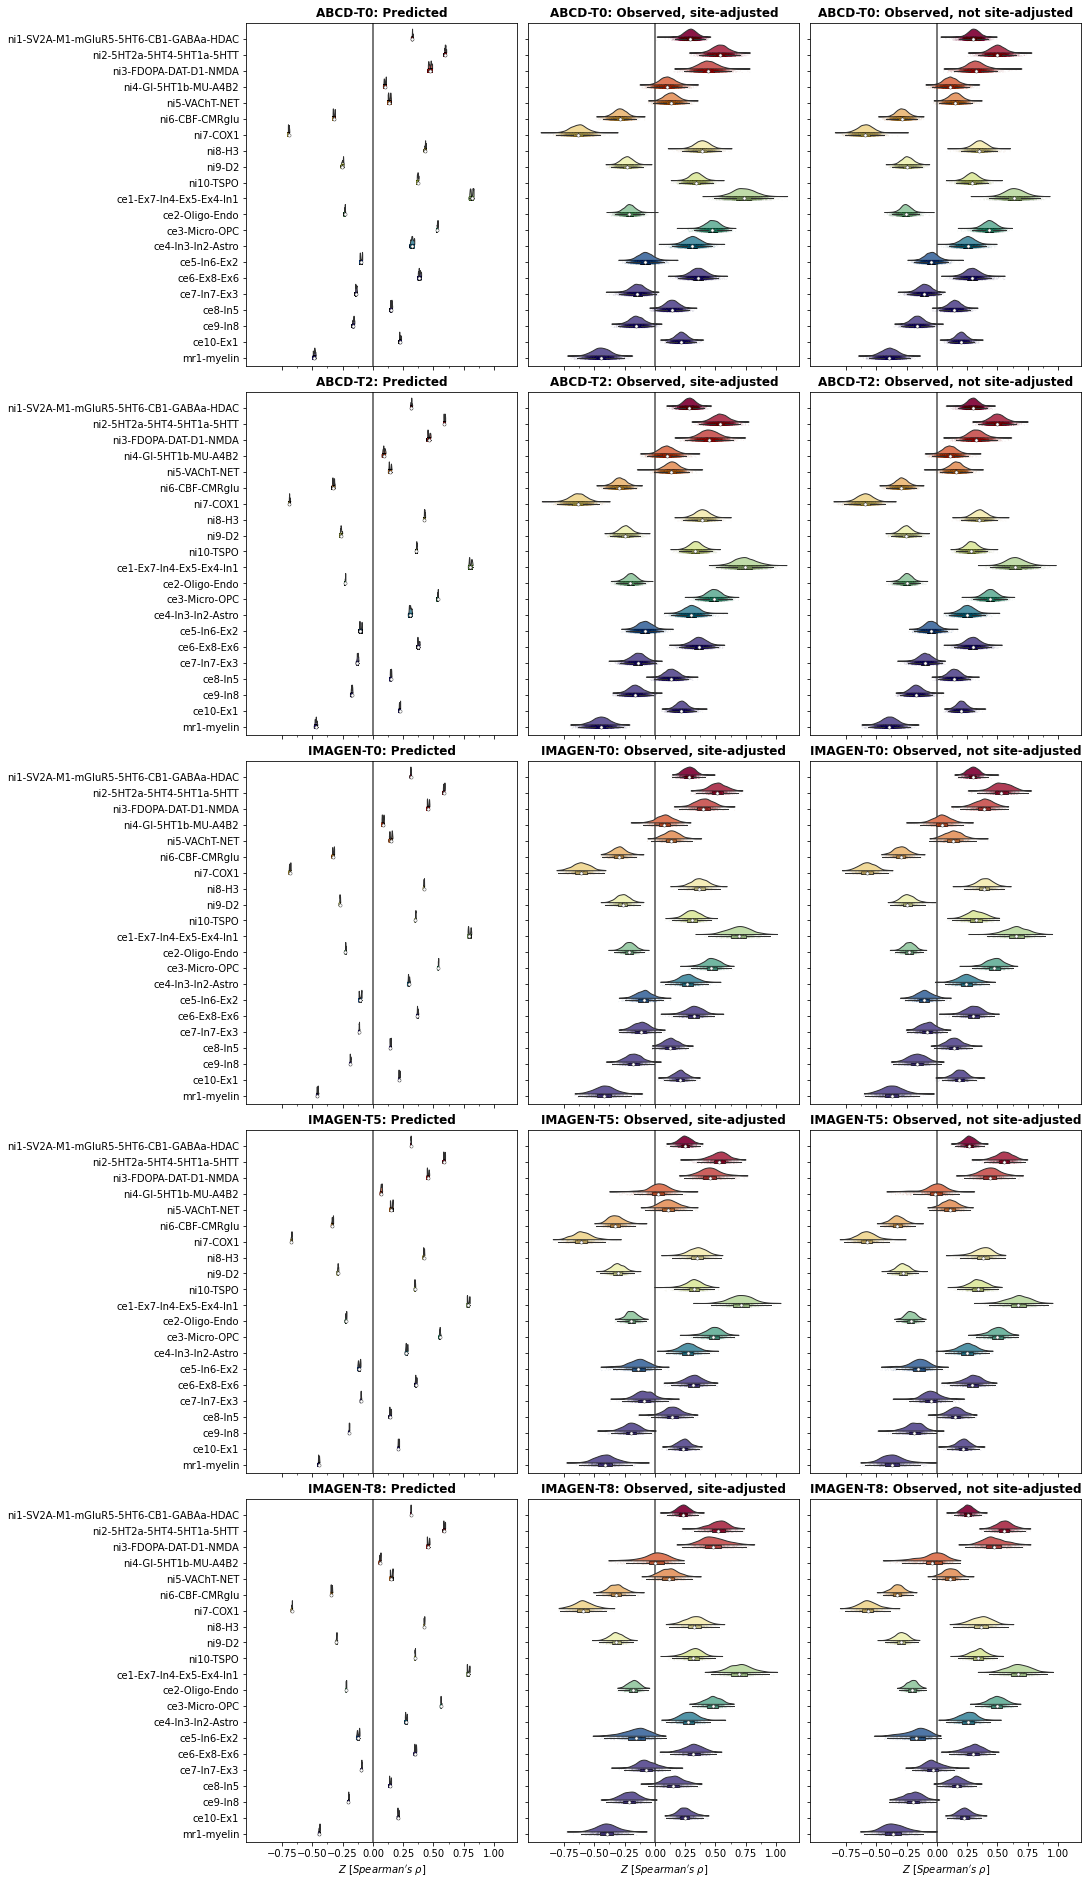

In [20]:
colors = get_cmap("Spectral")(np.arange(0,len(predictors)) * int(365/len(predictors)))

fig, axes = plt.subplots(n_tp,3, figsize=(15,26), sharey=True, sharex=True, constrained_layout=True)

# iterate analyses
for c, analysis, title in zip(
    range(3),
    ["pred", "rescaled", "orig"],
    ["Predicted", "Observed, site-adjusted", "Observed, not site-adjusted"]
):
    
    for r, ds_tp in enumerate(ds_tps):
        ds = ds_tp[0]
        tp = ds_tp[1]
        
        # predicted
        plot_raincloud(
            data=res_cross.loc[(ds, na(), tp, analysis)].melt(),
            x="value",
            y="variable",
            x_mean=res_cross.loc[(ds, na(), tp, analysis)].mean(),
            y_mean=range(len(predictors)),
            ax=axes[r,c],
            title="",
            xlab="",
            colors=colors
        )
        axes[r,c].axvline(0, c="0.3", zorder=0)

        axes[r,c].set_title(f"{'ABCD' if ds=='abcd' else 'IMAGEN'}-{tp}: {title}",
                            weight="semibold")
        axes[r,c].set_ylim((len(predictors)-0.5, -1))
        axes[r,c].set_yticklabels(predictors)
        axes[r,c].set_xticks(np.arange(-0.75, 1.1, 0.25))
        axes[r,c].set_xticks(np.arange(-0.75, 1.1, 0.125), minor=True)
    
        if r==n_tp-1:
            axes[r,c].set_xlabel(r"$Z\ [Spearman's\ \rho$]")
            
fig.savefig(join(plot_dir, "dev_ct_spearman.png"), bbox_inches="tight", dpi=300)

## Results: Longitudinal: prediction

### Can the Braincharts model predict regional CT change?  

In [21]:
cor = np.zeros((4, len(destrieux_idps)))

for i, ds_ts in enumerate(ds_tss):
    
    temp = data_delta.loc[(ds_ts[0], na(), ds_ts[1]), :]
    for ii, idp in enumerate(destrieux_idps): 
        cor[i, ii] = corr(
            temp[idp+"-delta"], 
            temp[idp+"-delta_pred"], 
            rank=True)
        
cor = pd.DataFrame(
    cor, 
    index=pd.MultiIndex.from_tuples(ds_tss), 
    columns=[i.replace("_thickness", "") for i in destrieux_idps])
cor.to_csv(join(abcdimgn_dir, "corr_delta_pred_obs.csv"))

print("Mean correlation per cohort:\n", cor.mean(1))
print("Max correlation per cohort:\n", cor.max(1))

cor

Mean correlation per cohort:
 abcd  T0T2    0.049793
imgn  T0T8    0.089078
      T0T5    0.164294
      T5T8    0.079012
dtype: float64
Max correlation per cohort:
 abcd  T0T2    0.114184
imgn  T0T8    0.287187
      T0T5    0.412441
      T5T8    0.195270
dtype: float64


lh_G&S_frontomargin  lh_G&S_occipital_inf  lh_G&S_paracentral  \
abcd T0T2             0.044613              0.064659            0.033945   
imgn T0T8             0.172960              0.183781            0.108755   
     T0T5             0.272833              0.223752            0.163199   
     T5T8             0.061100              0.118922            0.080791   

           lh_G&S_subcentral  lh_G&S_transv_frontopol  lh_G&S_cingul-Ant  \
abcd T0T2           0.048465                 0.041195           0.064668   
imgn T0T8           0.141856                 0.153176           0.021437   
     T0T5           0.286717                 0.281743           0.181818   
     T5T8           0.121142                 0.137181           0.129150   

           lh_G&S_cingul-Mid-Ant  lh_G&S_cingul-Mid-Post  \
abcd T0T2               0.060813                0.065607   
imgn T0T8               0.021254               -0.037467   
     T0T5               0.234484                0.136613   
     T5T8               0.059399                0.064392   

           lh_G_cingul-Post-dorsal  lh_G_cingul-Post-ventral  ...  \
abcd T0T2                 0.035414                  0.050910  ...   
imgn T0T8                -0.036360                  0.034271  ...   
     T0T5                 0.047986                  0.013450  ...   
     T5T8                 0.063926                  0.008589  ...   

           rh_S_parieto_occipital  rh_S_pericallosal  rh_S_postcentral  \
abcd T0T2                0.113677           0.009629          0.080047   
imgn T0T8                0.167307          -0.013610          0.112114   
     T0T5                0.199733           0.016603          0.173717   
     T5T8                0.129435          -0.013293          0.045510   

           rh_S_precentral-inf-part  rh_S_precentral-sup-part  \
abcd T0T2                  0.055091                  0.034536   
imgn T0T8                  0.093615                  0.131911   
     T0T5                  0.214559                  0.243419   
     T5T8                  0.048597                  0.094015   

           rh_S_suborbital  rh_S_subparietal  rh_S_temporal_inf  \
abcd T0T2         0.045811          0.047768           0.040433   
imgn T0T8         0.076604          0.094576          -0.129872   
     T0T5         0.152875          0.182452          -0.101991   
     T5T8         0.070266          0.016086           0.095415   

           rh_S_temporal_sup  rh_S_temporal_transverse  
abcd T0T2           0.096043                  0.021935  
imgn T0T8          -0.045989                 -0.049369  
     T0T5           0.031619                  0.004069  
     T5T8           0.077190                  0.016361  

[4 rows x 148 columns]

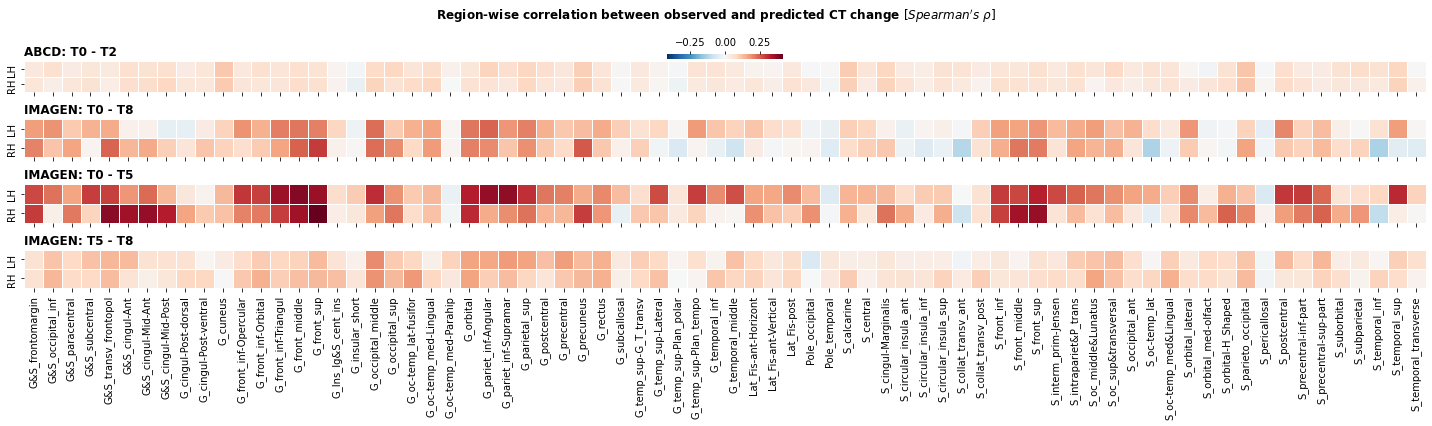

In [22]:
fig, axes = plt.subplots(cor.shape[0],1, figsize=(20,6), sharex=True)

lim = cor.abs().max().max()

for r, ds_ts in enumerate(ds_tss):
    
    sns.heatmap(
        np.vstack([cor.iloc[r,:74], cor.iloc[r,74:]]), 
        linewidths=1,
        cmap="RdBu_r",
        center=0,
        vmin=-lim,
        vmax=lim,
        ax=axes[r],
        cbar=True if r==0 else False,
        cbar_kws=dict(location="top")
    )
    
    axes[r].set_xticklabels([c.replace("lh_","") for c in cor.iloc[:1,:74].columns], rotation=90)
    axes[r].set_yticklabels(["LH", "RH"], va="center")
    axes[r].set_title(f"{'ABCD' if ds_ts[0]=='abcd' else 'IMAGEN'}: {ds_ts[1][:2]} - {ds_ts[1][2:]}", 
                      loc="left", weight="semibold")
    
fig.suptitle("Region-wise correlation between observed and predicted CT change " + r"$[Spearman's\ \rho]$", weight="semibold")
fig.tight_layout()
plt.savefig(join(plot_dir, f"dev_delta_correlation.pdf"), bbox_inches="tight")

### Can we predict single-subject CT change from multimodal predictors? 

In [23]:
print("CT-change [%]: Cohort average")
display(res_delta_allmean.round(3))
display(sig_delta)
print("CT-change [%]: Site average")
display(res_delta_sitemean.groupby("ts").mean().round(3))
display(sig_delta_sitemean)
print("CT-change [%]: Single-subject average")
display(res_delta.loc[(na(), na(), na(), "delta")].groupby("ts").mean().round(3))
display(sig_delta_allmean)

CT-change [%]: Cohort average


full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  \
ds   ts                                                            
abcd T0T2    0.405                 0.003           0.022   0.118   
imgn T0T8    0.490                 0.179           0.028   0.116   
     T0T5    0.565                 0.136           0.042   0.152   
     T5T8    0.245                 0.140           0.018   0.025   

           ce3-Micro-OPC  ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  \
ds   ts                                                             
abcd T0T2          0.199              0.004        0.019    0.039   
imgn T0T8          0.026              0.008        0.122    0.011   
     T0T5          0.062              0.005        0.157    0.010   
     T5T8         -0.001              0.012        0.047    0.004   

           spearman_ni4-GI-5HT1b-MU-A4B2  spearman_ni6-CBF-CMRglu  \
ds   ts                                                             
abcd T0T2                         -0.126                   -0.254   
imgn T0T8                         -0.656                   -0.256   
     T0T5                         -0.634                   -0.322   
     T5T8                         -0.500                   -0.091   

           spearman_ni9-D2  spearman_ce3-Micro-OPC  \
ds   ts                                              
abcd T0T2           -0.520                   0.512   
imgn T0T8           -0.440                   0.227   
     T0T5           -0.477                   0.321   
     T5T8           -0.228                   0.115   

           spearman_ce4-In3-In2-Astro  spearman_ce5-In6-Ex2  spearman_ce9-In8  
ds   ts                                                                        
abcd T0T2                       0.064                -0.173            -0.254  
imgn T0T8                       0.140                -0.516            -0.242  
     T0T5                       0.103                -0.562            -0.215  
     T5T8                       0.135                -0.338            -0.170

full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  \
ds   ts                                                            
abcd T0T2    0.001                 0.183           0.374   0.045   
imgn T0T8    0.001                 0.015           0.527   0.140   
     T0T5    0.001                 0.044           0.511   0.145   
     T5T8    0.001                 0.002           0.472   0.266   

           ce3-Micro-OPC  ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  
ds   ts                                                            
abcd T0T2          0.001              0.032        0.065    0.048  
imgn T0T8          0.255              0.202        0.014    0.210  
     T0T5          0.132              0.202        0.023    0.156  
     T5T8          0.139              0.041        0.052    0.118

CT-change [%]: Site average


full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  ce3-Micro-OPC  \
ts                                                                           
T0T2    0.304                 0.008           0.016   0.076          0.127   
T0T5    0.390                 0.070           0.026   0.117          0.059   
T0T8    0.307                 0.082           0.018   0.073          0.029   
T5T8    0.199                 0.049           0.016   0.046          0.019   

      ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  spearman_ni4-GI-5HT1b-MU-A4B2  \
ts                                                                             
T0T2              0.016        0.018    0.043                         -0.104   
T0T5              0.012        0.083    0.023                         -0.371   
T0T8              0.014        0.078    0.013                         -0.395   
T5T8              0.023        0.042    0.004                         -0.230   

      spearman_ni6-CBF-CMRglu  spearman_ni9-D2  spearman_ce3-Micro-OPC  \
ts                                                                       
T0T2                   -0.192           -0.383                   0.392   
T0T5                   -0.250           -0.388                   0.270   
T0T8                   -0.173           -0.334                   0.148   
T5T8                    0.005           -0.169                  -0.041   

      spearman_ce4-In3-In2-Astro  spearman_ce5-In6-Ex2  spearman_ce9-In8  
ts                                                                        
T0T2                       0.061                -0.125            -0.203  
T0T5                       0.090                -0.336            -0.158  
T0T8                       0.070                -0.323            -0.151  
T5T8                      -0.045                -0.163            -0.081

full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  \
ds   ts                                                            
abcd T0T2    0.001                 0.730           0.464   0.026   
imgn T0T8    0.001                 0.032           0.546   0.043   
     T0T5    0.001                 0.104           0.400   0.014   
     T5T8    0.001                 0.073           0.522   0.086   

           ce3-Micro-OPC  ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  
ds   ts                                                            
abcd T0T2          0.001              0.257        0.378    0.016  
imgn T0T8          0.324              0.422        0.012    0.416  
     T0T5          0.091              0.575        0.023    0.211  
     T5T8          0.364              0.114        0.064    0.733

CT-change [%]: Single-subject average


full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  ce3-Micro-OPC  \
ts                                                                           
T0T2    0.089                 0.011           0.007   0.015          0.024   
T0T5    0.162                 0.038           0.012   0.026          0.023   
T0T8    0.180                 0.051           0.013   0.029          0.020   
T5T8    0.129                 0.037           0.010   0.015          0.018   

      ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  spearman_ni4-GI-5HT1b-MU-A4B2  \
ts                                                                             
T0T2              0.011        0.012    0.009                         -0.015   
T0T5              0.014        0.035    0.013                         -0.182   
T0T8              0.015        0.040    0.012                         -0.229   
T5T8              0.017        0.021    0.011                         -0.087   

      spearman_ni6-CBF-CMRglu  spearman_ni9-D2  spearman_ce3-Micro-OPC  \
ts                                                                       
T0T2                   -0.035           -0.072                   0.074   
T0T5                   -0.116           -0.149                   0.105   
T0T8                   -0.089           -0.161                   0.069   
T5T8                   -0.007           -0.050                  -0.006   

      spearman_ce4-In3-In2-Astro  spearman_ce5-In6-Ex2  spearman_ce9-In8  
ts                                                                        
T0T2                       0.013                -0.017            -0.046  
T0T5                       0.043                -0.168            -0.068  
T0T8                       0.042                -0.183            -0.091  
T5T8                       0.005                -0.058            -0.032

full_r2  ni4-GI-5HT1b-MU-A4B2  ni6-CBF-CMRglu  ni9-D2  \
ds   ts                                                            
abcd T0T2    0.001                 0.704           0.356   0.021   
imgn T0T8    0.001                 0.011           0.349   0.046   
     T0T5    0.001                 0.067           0.320   0.047   
     T5T8    0.003                 0.004           0.257   0.194   

           ce3-Micro-OPC  ce4-In3-In2-Astro  ce5-In6-Ex2  ce9-In8  
ds   ts                                                            
abcd T0T2          0.001              0.521        0.374    0.080  
imgn T0T8          0.351              0.497        0.017    0.437  
     T0T5          0.190              0.641        0.022    0.525  
     T5T8          0.719              0.269        0.052    0.446

#### Main results plot

##### Combined prediction performance

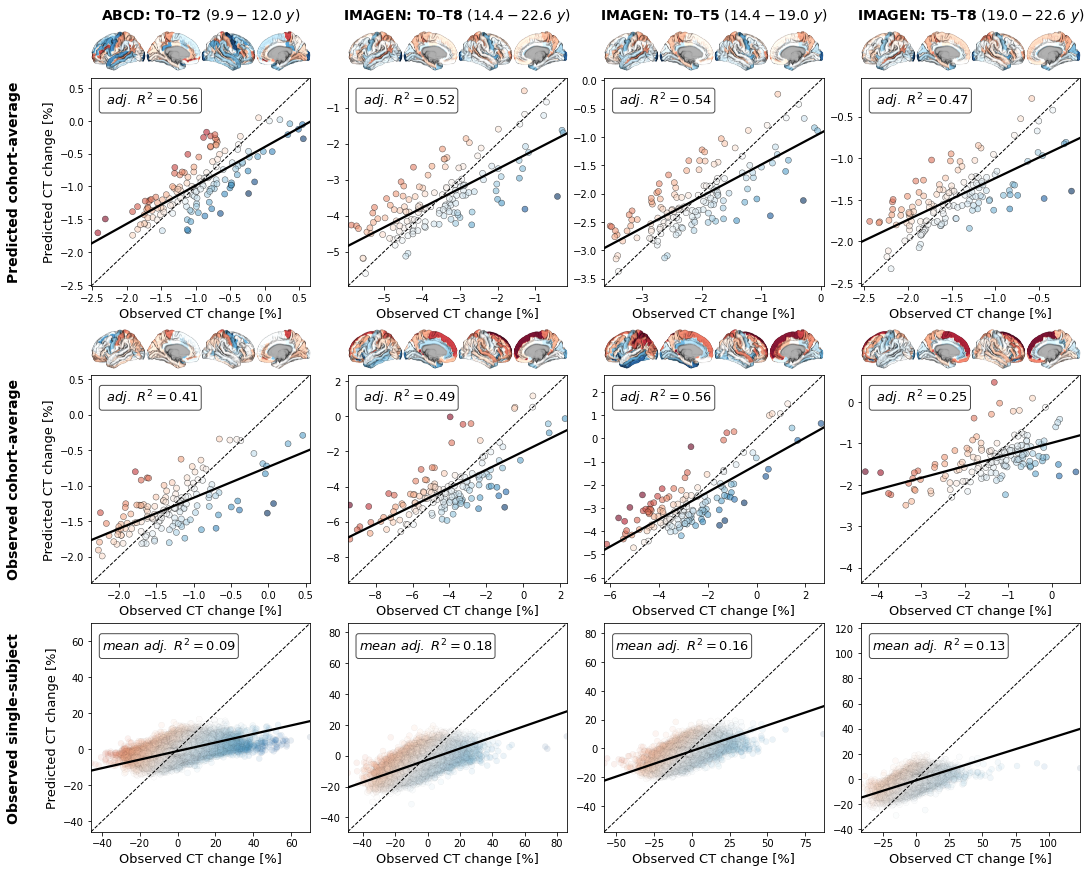

In [66]:
# MLR stats
def mlr(x, y):    
    X = np.c_[x, np.ones(x.shape[0])] 
    beta = np.linalg.pinv((X.T).dot(X)).dot(X.T.dot(y))
    y_hat = np.dot(X, beta)
    pe = y_hat - y
    ss_res = np.sum((y-y_hat)**2)       
    ss_tot = np.sum((y-np.mean(y))**2)   
    r2 = 1 - ss_res / ss_tot  
    r2 = 1 - (1-r2) * (len(y)-1) / (len(y)-x.shape[1]-1)
    return y_hat, pe, r2

# predictor data
x = predictors_destrieux[predictors_both].values
nonan = ~np.isnan(x).any(1)
 
# estimate and plot
fig, axes = plt.subplots(3, len(ds_tss), figsize=(15,12), constrained_layout=True,
                         gridspec_kw=dict())

for c, (ds, ts) in enumerate(ds_tss):
    
    for r, df in enumerate([data_delta_long.loc[(ds, na(), ts, "delta_pred")].mean(),
                            data_delta_long_allmean.loc[(ds,ts)],
                            data_delta_long.loc[(ds, na(), ts, "delta")]]):
        
        y = df.values * 100
        y_, pe = y.copy(), y.copy()
        y_[:], pe[:] = np.nan, np.nan
        
        if r<2:
            y_[nonan], pe[nonan], r2 = mlr(x=x[nonan,:], y=y[nonan])
        elif r==2:
            r2 = np.zeros(df.shape[0])
            for i in range(df.shape[0]): 
                y_[i,nonan], pe[i,nonan], r2[i] = mlr(x=x[nonan,:], y=y[i,nonan]) 
            r2 = np.mean(r2)
        
        lim = (np.nanmin([np.nanmin(y_), np.nanmin(y)]) - 0.1, 
               np.nanmax([np.nanmax(y_), np.nanmax(y)]) + 0.1)
        pe_lim = np.nanmax(np.abs(pe))
        
        if r<2:
            ax = axes[r,c].inset_axes((0, 1, 1, 0.25))
            lh, rh = get_parc_gifti(pe if r<2 else np.nanmean(pe, 0), parc_destrieux)
            plot_surf_ax(ax=ax, fig=fig, lh=lh, rh=rh, c="RdBu_r", c_lims=(-pe_lim, pe_lim))
            ax.set_axis_off()

        axes[r,c].scatter(
            x=y, 
            y=y_, 
            c=pe, 
            vmin=-pe_lim,
            vmax=pe_lim,
            cmap="RdBu_r",
            ec="k",
            lw=0.5 if r<2 else 0.2,
            alpha=0.6 if r<2 else 0.1
        )
        axes[r,c].plot([lim[0], lim[1]], [lim[0], lim[1]], c="k", lw=1, ls="--")
        sns.regplot(x=y.flatten(), y=y_.flatten(), scatter=False, ci=None, ax=axes[r,c], truncate=False, color="k")

        axes[r,c].annotate(
            f"${'mean' if r==2 else ''}\ adj.\ R^2={r2:.02f}$",
            xy=(0.05,0.87),
            ha="left",
            size=13,
            xycoords="axes fraction",
            bbox=dict(boxstyle="round,pad=0.2", fc="w", alpha=0.7)
        )
        
        axes[r,c].set_xlim(lim)
        axes[r,c].set_ylim(lim)
        
        if r==0:
            axes[r,c].set_title(f"{'ABCD' if ds=='abcd' else 'IMAGEN'}: {ts[:2]}–{ts[2:]} $({tss_age_exact[c][0]:.01f}-{tss_age_exact[c][1]:.01f}\ y)$", 
                                weight="semibold", size=14, pad=10)
        if c==0:
            axes[r,c].set_ylabel("Predicted CT change [%]", size=13)
        axes[r,c].set_xlabel("Observed CT change [%]", size=13)
            
[axes[r,0].annotate(
    title, weight="semibold", xy=(-0.35,0.5), xycoords="axes fraction", ha="center", va="center", 
    rotation=90, size=14
) for r, title in enumerate(
    ["Predicted cohort-average", "Observed cohort-average", "Observed single-subject"]
)]

plt.savefig(join(plot_dir, f"dev_delta_main_overall.png"), bbox_inches="tight", dpi=300)

##### Predictor-level comparison

INFO:juspyce.api:Loaded complete object from /Users/llotter/projects/ntct/data_rutherford/juspyce_ct_dominance_fm_500_5.pkl.gz.


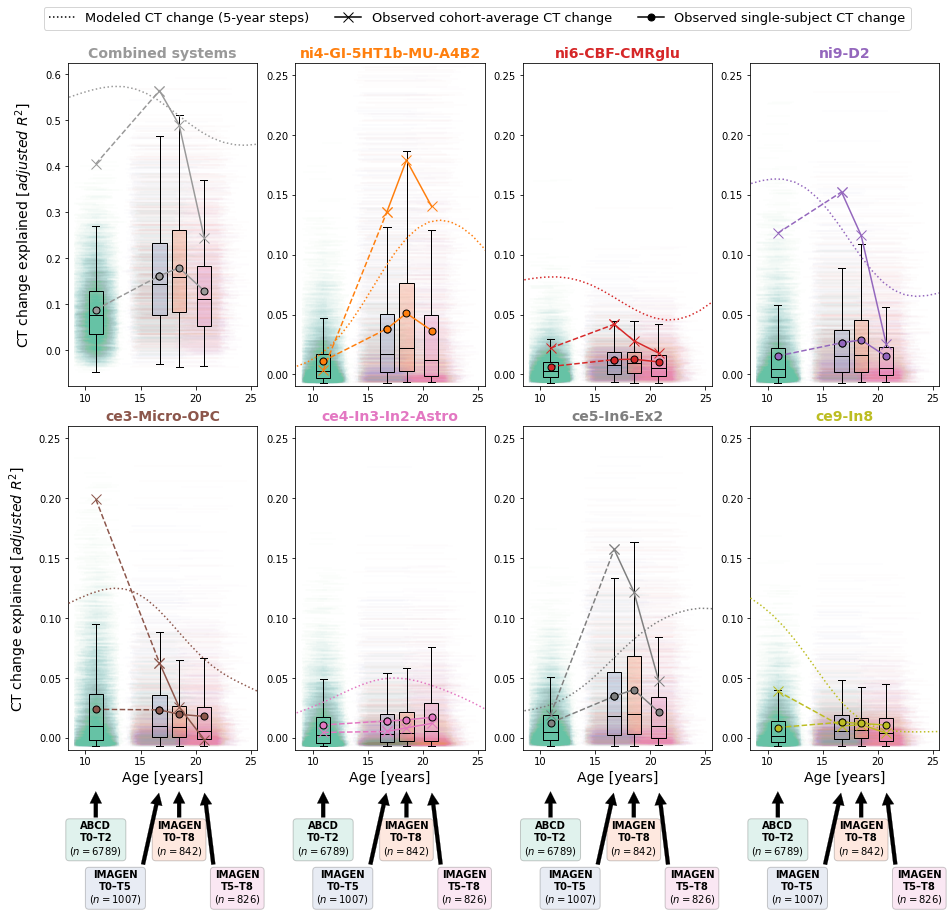

In [67]:
juspyce_ct_dominance = JuSpyce.from_pickle(join(wd, "data_rutherford", "juspyce_ct_dominance_fm_500_5.pkl.gz"))

fig, axes = plt.subplots(3,4, figsize=(13,12), constrained_layout=True,
                         gridspec_kw=dict(height_ratios=[1,1,0.3]))
axes = axes.ravel()

# color sets
pred_colors = np.row_stack([np.array([0.6,0.6,0.6,1]), c_predictors_both])
cohort_colors = sns.color_palette("Set2", 4)

# iterate predictors
for i, pred in enumerate(["full_r2"] + predictors_both):
    
    # iterate datasets
    for (ds, ts), color in zip(ds_tss, cohort_colors):
        
        # subjects and subject age
        subs = res_delta.loc[ds,na(),ts,"delta"].index.get_level_values("id").to_list()
        subs_age1 = data_cross.loc[ds,subs,ts[:2]].age.values
        subs_age2 = data_cross.loc[ds,subs,ts[2:]].age.values        

        # datasets
        data = res_delta.loc[(ds,subs,ts,"delta"), pred]
        if pred=="full_r2":
            data_model = juspyce_ct_dominance.predictions["dominance_full_r2"].iloc[1:,0]
        else:
            data_model = juspyce_ct_dominance.predictions["dominance_total"][pred][1:]
        data_model.index = np.arange(5,86,1) + 2.5
        
        # horizontal line for each subject, across each subject's exact investigated time span
        axes[i].hlines(
            xmin=subs_age1, 
            xmax=subs_age2,
            y=data,
            alpha=0.015,
            color=color
        )
        
        # boxplot for each cohort's mean
        axes[i].boxplot(
            x=data,
            positions=[( (subs_age1 + subs_age2)/2 ).mean()],
            showfliers=False,
            widths=1.3,
            patch_artist=True,
            boxprops=dict(facecolor=color + (0.3,)),
            medianprops=dict(c="k"),
            manage_ticks=False,
            zorder=90
        )

    # Modeled CT change over 5-year steps as shown in the first analyses for comparison
    axes[i].plot(
        data_model.index,
        data_model,
        c=pred_colors[i],
        linestyle=":",
        label="Modeled CT change (5-year steps)",
        zorder=100
    )

    # connect time spans and plot mean points for each time span
    # two connection line styles, because ABCD -> IMAGEN shown differently
    for idc, linestyle in zip([[0,2], [2,1,3]], ["--", "-"]):
        
        # Cohort average
        axes[i].plot(
            np.array(tss_age_mean)[idc],
            res_delta_allmean[pred][idc],
            c=pred_colors[i],
            marker="x",
            markersize=10,
            linestyle=linestyle,
            label="Observed cohort-average CT change" if linestyle=="-" else None,
            zorder=100
        )
        
        # Single subject average
        axes[i].plot(
            np.array(tss_age_mean)[idc],
            res_delta.loc[(na(),na(),na(),"delta"), pred].groupby("ts").mean()[tss][idc],
            c=pred_colors[i],
            marker="o",
            markeredgecolor="k",
            markersize=7,
            linestyle=linestyle,
            label="Observed single-subject CT change" if linestyle=="-" else None,
            zorder=100
        )

    # general
    axes[i].set_title(pred if pred!="full_r2" else "Combined systems", color=pred_colors[i], 
                      size=14, weight="semibold")
    axes[i].set_xlim(data_cross.age.min()-0.5, data_cross.age.max()+0.5)
    if i>0:
        axes[i].set_ylim(-0.01, 0.26)
        
axes = axes.reshape((3,4)) 
[axes[r,0].set_ylabel("CT change explained [$adjusted\ R^2$]", size=14, labelpad=10) for r in range(2)]
[axes[1,c].set_xlabel("Age [years]", size=14) for c in range(4)]
        
# Cohort/time span annotations at the bottom of the plot
for i, (ds, ts) in enumerate(ds_tss):
    for c in range(4):
        ytext = [0.5, 0.5, 0, 0]
        xtext = tss_age_mean[i] + np.array([0, 0, -4, 3])
        t = axes[2,c].annotate(
            f"{'ABCD' if ds=='abcd' else 'IMAGEN'}\n"
            f"{ts[:2]}–{ts[2:]}\n"
            f"$(n={res_delta.loc[(ds, na(), ts, 'delta'),].shape[0]})$",
            xy=(tss_age_mean[i], 1),
            xytext=(xtext[i], ytext[i]),
            weight="semibold",
            ha="center",
            va="center",
            zorder=100,
            arrowprops=dict(facecolor='k', shrink=0.03, lw=0.2, zorder=90),
            bbox=dict(boxstyle="round,pad=0.35", fc=cohort_colors[i], alpha=0.2, zorder=100)
        )
        axes[2,c].set_axis_off()
        axes[2,c].set_ylim(0,1)
        axes[2,c].set_xlim(data_cross.age.min()-0.5, data_cross.age.max()+0.5)  

# legend
handles, labels = axes[0,0].get_legend_handles_labels()
handles = [copy.copy(h) for h in handles]
[h.set_color("k") for h in handles]
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5,1.05), ncol=3, labelcolor="k",
           fontsize=13)

# save
plt.savefig(join(plot_dir, f"dev_delta_main_predictors.png"), bbox_inches="tight", dpi=300)

#### Full R2 distributions

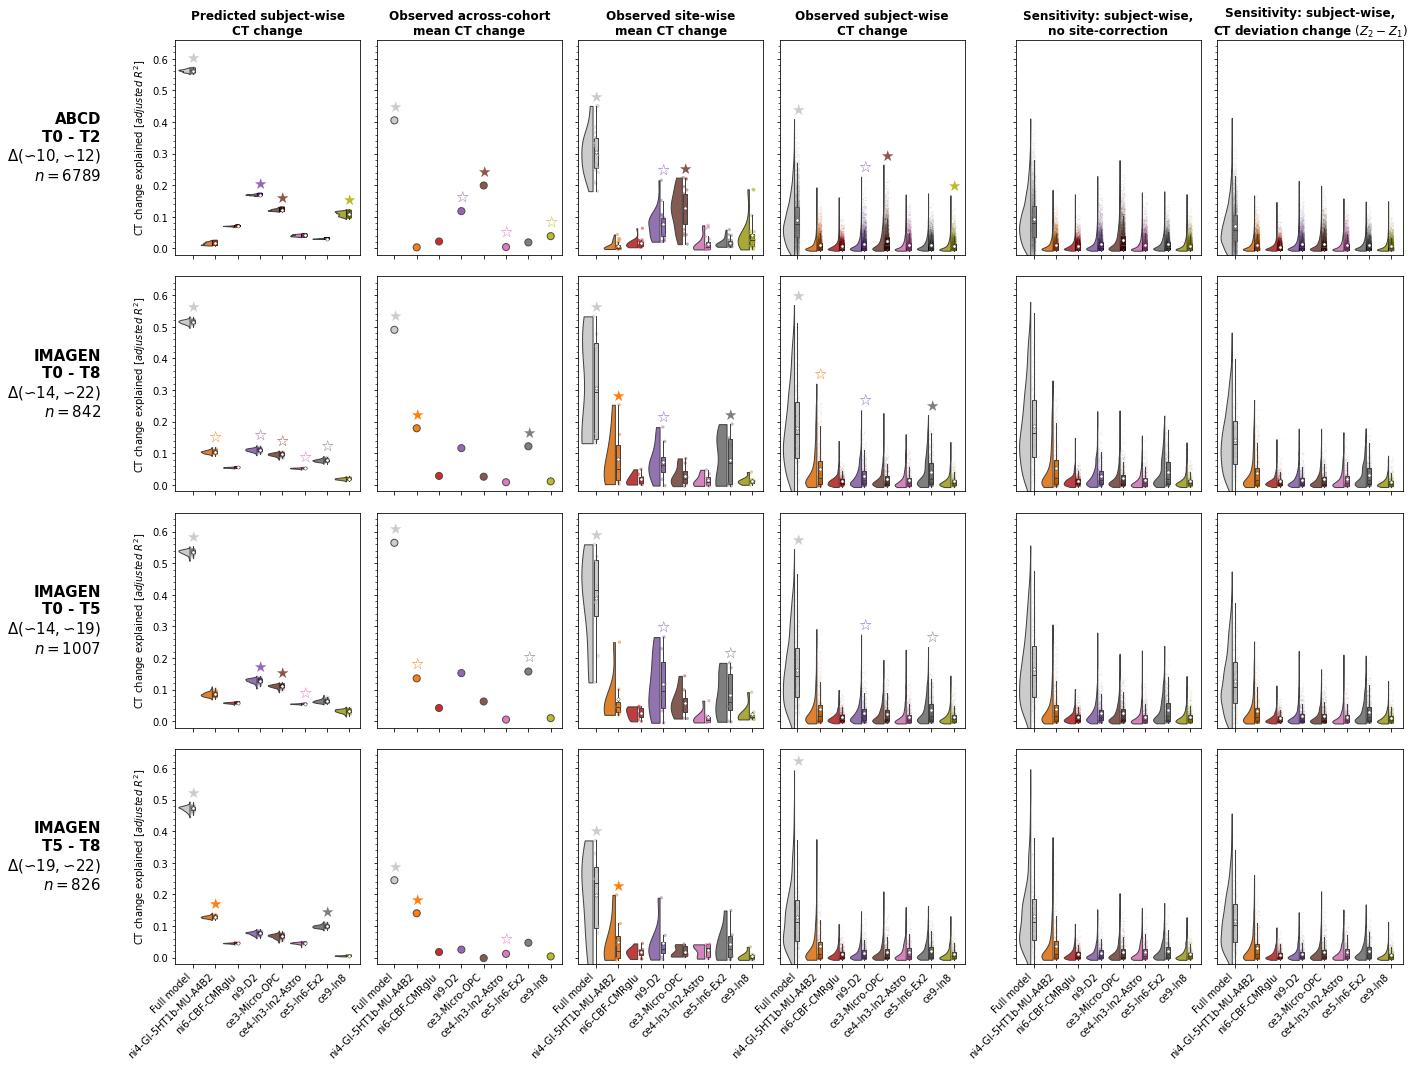

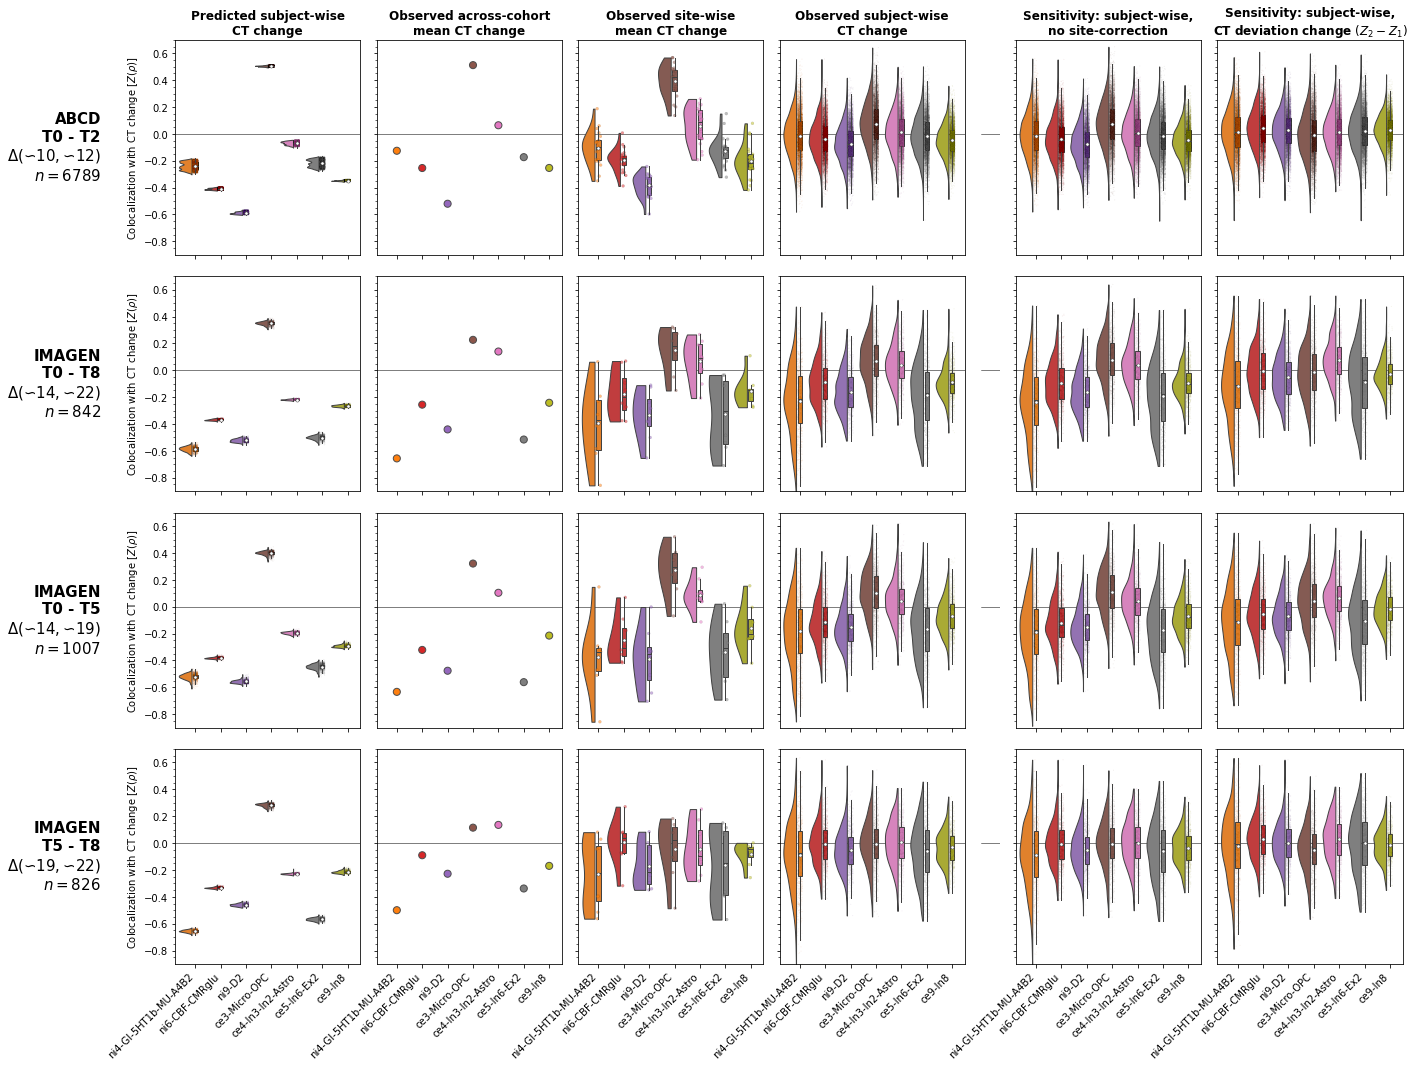

In [28]:
for analysis, pred, ylab, colors in zip(
    ["dominance", "spearman"],
    [["full_r2"] + predictors_both, ["spearman_"+p for p in predictors_both]],
    ["CT change explained [$adjusted\ R^2$]", "Colocalization with CT change "+r"[$Z(\rho)$]"],
    [np.vstack([c_full_model, c_predictors_both]), np.vstack([c_predictors_both])]
):

    fig, axes = plt.subplots(n_ts, 7, figsize=(22,17), sharey="row", sharex="col",
                             gridspec_kw=dict(hspace=0.1, wspace=0.1, 
                                              width_ratios=(1,1,1,1,0.1,1,1)))
    
    for r, ds_ts, ts_age in zip(range(n_ts), ds_tss, tss_age):
        ds = ds_ts[0]
        ts = ds_ts[1]
        
        # predicted
        plot_raincloud(
            data=res_delta.loc[(ds, na(), ts, "delta_pred"), pred].melt(),
            x="variable",
            y="value",
            x_mean=range(len(pred)),
            y_mean=res_delta.loc[(ds, na(), ts, "delta_pred"), pred].mean(),
            ax=axes[r,0],
            ylab=ylab,
            colors=colors
        )
        axes[r,0].set_title("Predicted subject-wise\nCT change" if r==0 else "", weight="semibold")
        
        # cohort mean
        sns.scatterplot(
            y=res_delta_allmean.loc[(ds, ts), pred],
            x=pred,
            ax=axes[r,1],
            c=colors,
            s=50,
            linewidth=1,
            edgecolor="0.3"
        )
        axes[r,1].set_title("Observed across-cohort\nmean CT change" if r==0 else "", weight="semibold")
        axes[r,1].set_xlabel("")
        
        # site mean
        plot_raincloud(
            data=res_delta_sitemean.loc[(na(), ds, ts), pred].melt(),
            x="variable",
            y="value",
            x_mean=range(len(pred)),
            y_mean=res_delta_sitemean.loc[(na(), ds, ts), pred].mean(),
            ax=axes[r,2],
            colors=colors,
            scatter_a=0.5, scatter_s=3
        )
        axes[r,2].set_title("Observed site-wise\nmean CT change" if r==0 else "", weight="semibold")
        
        # individual
        plot_raincloud(
            data=res_delta.loc[(ds, na(), ts, "delta"), pred].melt(),
            x="variable",
            y="value",
            x_mean=range(len(pred)),
            y_mean=res_delta.loc[(ds, na(), ts, "delta"), pred].mean(),
            ax=axes[r,3],
            colors=colors
        )
        axes[r,3].set_title("Observed subject-wise\nCT change" if r==0 else "", weight="semibold")
        
        # sensitivity analyses
        axes[r,4].set_axis_off()
        for i_sens, (sens_analysis, title) in enumerate(zip(
            ["delta_orig", "z_delta"],
            ["Sensitivity: subject-wise,\nno site-correction",
             "Sensitivity: subject-wise,\nCT deviation change $(Z_2-Z_1)$"]
        )):
            plot_raincloud(
                data=res_delta.loc[(ds, na(), ts, sens_analysis), pred].melt(),
                x="variable",
                y="value",
                x_mean=range(len(pred)),
                y_mean=res_delta.loc[(ds, na(), ts, sens_analysis), pred].mean(),
                ax=axes[r,5+i_sens],
                colors=colors
            )
            axes[r,5+i_sens].set_title(title if r==0 else "", weight="semibold")
        
        # p values
        for c, (sig_df, max_df) in enumerate(zip(
            [sig_delta_pred, sig_delta, sig_delta_allmean, sig_delta_sitemean],
            [res_delta.loc[(ds, na(), ts, "delta_pred"), pred].max(),
             res_delta_allmean.loc[(ds, ts), pred],
             res_delta_sitemean.loc[(na(), ds, ts), pred].max(),
             res_delta.loc[(ds, na(), ts, "delta"), pred].max()]
        )):
            if (sig_df is not None) & (analysis!="spearman"):
                s = p_to_ast(pd.DataFrame(sig_df.loc[(ds, ts)]), mc_correction(sig_df.loc[(ds, ts), :]))
                for i, p in enumerate(pred):
                    axes[r,c].text(
                        s=s.iloc[i].values[0],
                        x=i,
                        y=max_df[i] + (0.015 if c!=1 else 0.03),
                        size=15,
                        c=colors[i],
                        ha="center"                     
                    )
        
        # dataset & timespan
        axes[r,0].annotate(
            f"{'ABCD' if ds=='abcd' else 'IMAGEN'}\n"
            f"{ts[:2]} - {ts[2:]}\n" 
            r"$\Delta(\backsim$" + f"${ts_age[0]},$" + r"$\backsim$" + f"${ts_age[1]})$\n"
            f"$n = {len(res_delta.loc[(ds, na(), ts, 'delta'), :])}$",
            xy=(-0.4,0.5), xycoords="axes fraction", rotation=0, weight="semibold",
            size=15, va="center", ha="right"
        )
        
        # layout
        for c in range(7):
            
            axes[r,c].set_xlim([-0.8, len(pred)-0.5])
            axes[r,c].set_xticks(range(len(pred)))
            
            if analysis=="dominance":
                axes[r,c].set_ylim([-0.02, 0.66])
                axes[r,c].set_yticks(np.arange(0, 0.66, 0.1))
                axes[r,c].set_yticks(np.arange(0, 0.66, 0.02), minor=True)
                axes[r,c].set_xticklabels(["Full model"] + predictors_both, rotation=45, ha="right")
                
            elif analysis=="spearman":
                axes[r,c].set_ylim([-0.9, 0.7])
                axes[r,c].set_yticks(np.arange(-0.8, 0.62, 0.2))
                axes[r,c].set_yticks(np.arange(-0.85, 0.72, 0.05), minor=True)
                axes[r,c].set_xticklabels(replace(pred, "spearman_"), rotation=45, ha="right")
                axes[r,c].axhline(0, c="k", lw=0.5, zorder=0)

    plt.savefig(join(plot_dir, f"dev_delta_full_{analysis}.png"), bbox_inches="tight", dpi=600)
    plt.show()

#### Do subject-level models transfer from Braincharts to true data?
"One size fits all?"

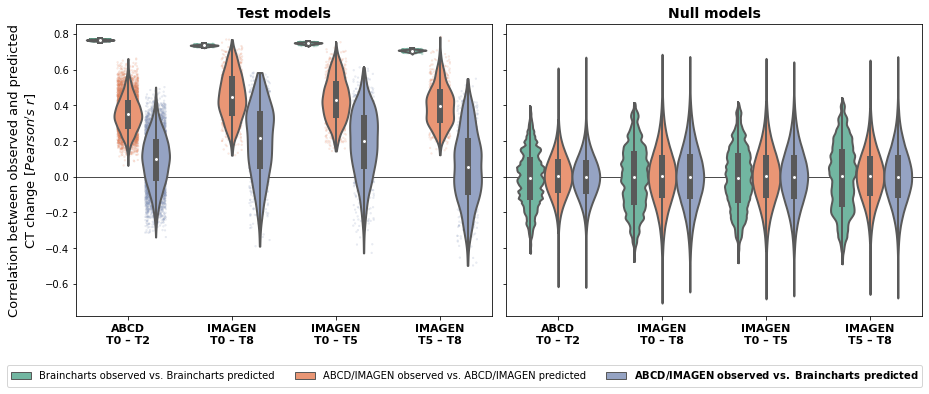

In [287]:
# prepare dataframes
res_transpred_melt = res_transpred \
    .reset_index() \
    .melt(id_vars=["ds", "id", "ts"])
res_transpred_null_melt = res_transpred_null \
    .reset_index() \
    .melt(id_vars=["ds", "id", "ts", "i"])
    

# plot
fig, axes = plt.subplots(1,2, figsize=(13,5), sharex=True, sharey=True)
colors = sns.color_palette("Set2", 3)

for c, (data, title) in enumerate(zip([res_transpred_melt, res_transpred_null_melt], 
                                      ["Test models", "Null models"])):
    
    if title=="Test models":
        sns.stripplot(
            data=data,
            y="value",
            x="ts",
            hue="variable",
            dodge=True,
            zorder=1,
            palette=colors,
            linewidth=0.1,
            size=2,
            alpha=0.2,
            jitter=0.3,
            ax=axes[c],
        )
    sns.violinplot(
        data=data,
        y="value",
        x="ts",
        hue="variable",
        zorder=10,
        linewidth=2,
        palette=colors,
        scale="width",
        cut=0,
        ax=axes[c],
    )
    
    axes[c].legend().remove()
    axes[c].axhline(0, c="0.3", zorder=0, lw=1)
    axes[c].set_xlabel("")
    axes[c].set_xticklabels([f"{'ABCD' if ds=='abcd' else 'IMAGEN'}\n{ts[:2]} – {ts[2:]}" for ds, ts in ds_tss], 
                            ha="center", weight="semibold", size=11)
    axes[c].set_ylabel("")
    axes[c].set_title(title, weight="semibold", size=14)
    
axes[0].set_ylabel("Correlation between observed and predicted\nCT change $[Pearson's\ r]$", 
                   size=13)

handles, labels = axes[0].get_legend_handles_labels()
labels[2] = r"$\bf{ABCD/IMAGEN\ observed\ vs.\ Braincharts\ predicted}$"
leg = fig.legend(handles[:3], labels[:3], ncol=3, loc="lower center", bbox_to_anchor=(0.5,-0.1))

fig.tight_layout()

plt.savefig(join(plot_dir, f"dev_delta_transfer.png"), bbox_inches="tight", dpi=300)

#### Systematic influences on CT explanation

In [29]:
# function to plot scatter and distribution
def plot_scattercloud(x, y, ax1, ax2, ax1_xlab="", ax2_xlab="", annot="right", color=None):
    sns.scatterplot(x=x.iloc[:,0], y=y, ax=ax1,
                    alpha=0.1,
                    size=20,
                    legend=False,
                    color=color)
    r, p = spearmanr(x,y, nan_policy="omit")
    p = f"p={p:.03f}" if p >= 0.001 else "p<0.001"
    ax1.annotate(
        fr"$\rho={r:.02f}$" + "\n" + fr"${p}$", 
        xy=(0.05 if annot=="left" else 0.95, 0.82), 
        xycoords="axes fraction", 
        ha=annot,
        va="center",
        bbox=dict(boxstyle="round, pad=0.2", fc="white", ec=color, alpha=0.5))
    ax1.set_xlabel(ax1_xlab)
    ax1.set_ylabel("")
    plot_raincloud(
        data=x.melt(),
        y="variable",
        x="value",
        x_mean=x.mean(),
        y_mean=0,
        ax=ax2,
        xlab=ax2_xlab,
        colors=None if color==None else [color] 
    )
    ax2.set_ylim(-0.8,0.2)
    ax2.set_yticks([])

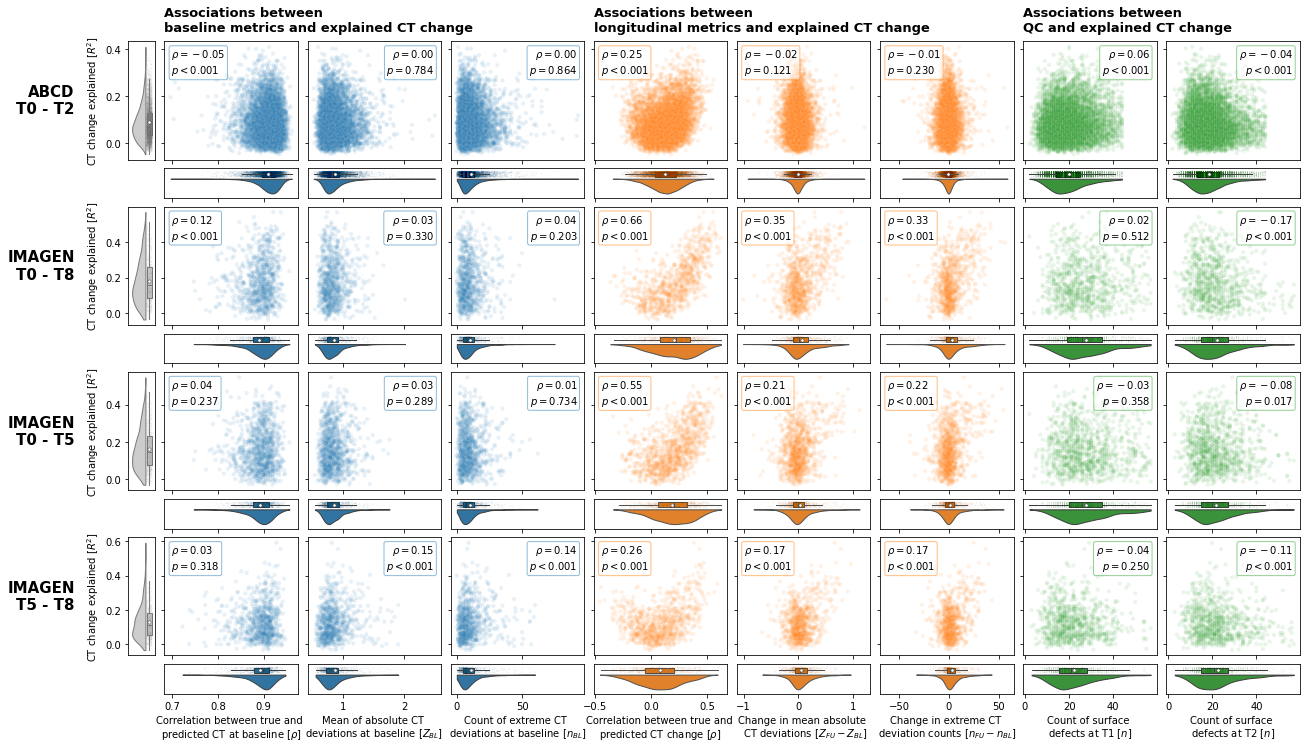

In [30]:
fig, axes = plt.subplots(2*n_ts, 1+8, figsize=(21,12), sharey="row", sharex="col",
                         gridspec_kw=dict(
                             width_ratios=(0.2, 1,1,1,1,1,1,1,1), 
                             height_ratios=[1, 0.25] * n_ts,
                             wspace=0.08,
                             hspace=0.12))

for r, ds_ts in zip(range(0, 2*n_ts, 2), ds_tss):
    ds = ds_ts[0]
    ts = ds_ts[1]
    subs = data_delta.loc[(ds, na(), ts), "id"].to_list()
    
    # R2 distribution
    plot_raincloud(
        data=res_delta.loc[(ds, subs, ts, "delta"), ["full_r2"]].melt(),
        x="variable",
        y="value",
        x_mean=0,
        y_mean=[res_delta.loc[(ds, subs, ts, "delta"), "full_r2"].mean()],
        ax=axes[r,0],
        ylab="CT change explained [$R^2$]",
        colors=[c_full_model]
    )
    #axes[0,0].set_yticks(np.arange(0,0.5,0.02), minor=True)
    axes[r,0].set_xlim(-0.8,0.2)
    axes[r,0].set_xticks([])
    axes[r+1,0].axis("off")
    
    # surface defects
    df_defects = abcd[["apqc_smri_topo_ndefect"]] if ds=="abcd" else imgn[["total_en"]]

    # Scatters
    for c, (x_lab, x, color, annot_site) in enumerate(zip(
        ["Correlation between true and \npredicted CT at baseline " + r"[$\rho$]",
         "Mean of absolute CT \ndeviations at baseline " + r"[$Z_{BL}$]",
         "Count of extreme CT \ndeviations at baseline " + r"[$n_{BL}$]",
         "Correlation between true and \npredicted CT change " + r"[$\rho$]",
         "Change in mean absolute \n CT deviations " + r"[$Z_{FU}-Z_{BL}$]",
         "Change in extreme CT \ndeviation counts " + r"[$n_{FU}-n_{BL}$]",
         "Count of surface \ndefects at T1 [$n$]",
         "Count of surface \ndefects at T2 [$n$]"],
        [data_cross.loc[(ds, subs, ts[:2]), ["summary-cor_pred_cross"]].reset_index(drop=True),
         data_cross.loc[(ds, subs, ts[:2]), ["summary-mean_abs_z"]].reset_index(drop=True),
         data_cross.loc[(ds, subs, ts[:2]), ["summary-n_extr_z"]].reset_index(drop=True),
         data_delta.loc[(ds, subs, ts), ["summary-cor_pred_delta"]].reset_index(drop=True),
         data_delta.loc[(ds, subs, ts), ["summary-diff_mean_abs_z"]].reset_index(drop=True),
         data_delta.loc[(ds, subs, ts), ["summary-diff_n_extr_z"]].reset_index(drop=True),
         df_defects.loc[(subs, ts[:2]), ].reset_index(drop=True),
         df_defects.loc[(subs, ts[2:]), ].reset_index(drop=True)],
        ["tab:blue"]*3 + ["tab:orange"]*3 + ["tab:green"]*2, 
        ["left", "right", "right", "left", "left", "left", "right", "right"]
    ), start=1):
    
        plot_scattercloud(
            x=x,
            y=res_delta.loc[(ds, subs, ts, "delta"), "full_r2"].reset_index(drop=True),
            ax1=axes[r, c], 
            ax2=axes[r+1, c], 
            color=color,
            annot=annot_site,
            ax2_xlab=x_lab
        )
    
    # dataset & timespan
    axes[r,0].annotate(
        f"{'ABCD' if ds=='abcd' else 'IMAGEN'}\n"
        f"{ts[:2]} - {ts[2:]}",
        xy=(-2,0.5), xycoords="axes fraction", 
        weight="semibold", size=15, va="center", ha="right"
    )
        
# Layout
[axes[0, c].set_title(
    f"Associations between\n{title} and explained CT change", loc="left", weight="semibold", pad=10, size=13) \
        for c, title in zip([1, 4, 7], ["baseline metrics", "longitudinal metrics", "QC"])]    


# remove all x labels except for the lowest row (no idea why we have to to this)
_ = [axes[r,c].set_xlabel("") for r in range(axes.shape[0]-1) for c in range(axes.shape[1])]

plt.savefig(join(plot_dir, f"dev_deviation_associations.png"), bbox_inches="tight", dpi=400)

#### Does CT change prediction vary by follow-up duration?

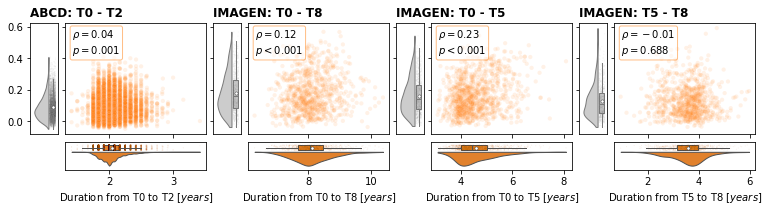

In [31]:
fig, axes = plt.subplots(2, n_ts*2, figsize=(13,2.7), sharey="row",
                         gridspec_kw=dict(width_ratios=(0.2,1, 0.2,1, 0.2,1, 0.2,1),
                                          height_ratios=[1, 0.25],
                                          wspace=0.08,
                                          hspace=0.12))

for c, (ds, ts) in zip(range(0, n_ts*2, 2), ds_tss):
    subs = data_delta.loc[(ds, na(), ts), "id"].to_list()
    df = abcd if ds=="abcd" else imgn
    
    # R2 distribution
    plot_raincloud(
        data=res_delta.loc[(ds, subs, ts, "delta"), ["full_r2"]].melt(),
        x="variable",
        y="value",
        x_mean=0,
        y_mean=[res_delta.loc[(ds, subs, ts, "delta"), "full_r2"].mean()],
        ax=axes[0,c],
        ylab="CT change explained [$R^2$]" if r==0 else "",
        colors=[c_full_model]
    )
    axes[0,c].set_xlim(-0.8,0.2)
    axes[0,c].set_xticks([])
    axes[1,c].set_axis_off()

    x = df[["age"]].copy()
    x.loc[(subs, ts[2:]), "age_diff"] = df.loc[(subs, ts[2:]), "age"].values - df.loc[(subs, ts[:2]), "age"].values
    plot_scattercloud(
        x=x.loc[(subs, ts[2:]), ["age_diff"]].reset_index(drop=True),
        y=res_delta.loc[(ds, subs, ts, "delta"), "full_r2"].reset_index(drop=True),
        ax1=axes[0, c+1], 
        ax2=axes[1, c+1], 
        color="tab:orange",
        annot="left",
        ax2_xlab=f"Duration from {ts[:2]} to {ts[2:]} $[years]$"
    )
    axes[0, c+1].set_xlabel("")
    axes[0, c+1].set_xticklabels([])
    
    axes[0,c].set_title(f"{'ABCD' if ds=='abcd' else 'IMAGEN'}: {ts[:2]} - {ts[2:]}", 
                        weight="semibold", loc="left")
    
plt.savefig(join(plot_dir, f"dev_fu_duration.png"), bbox_inches="tight", dpi=300)

#### Does CT change prediction vary by sex or site?

    Group A Group B     T      df  p-FDR     g
0      CHLA     CUB  3.03  346.20  0.013  0.28
1      CHLA     FIU  3.14  338.17  0.010  0.30
2      CHLA    LIBR  2.40  291.04  0.061  0.23
3      CHLA    MUSC -0.67  413.45  0.648 -0.06
4      CHLA    OHSU  3.79  313.44  0.002  0.36
..      ...     ...   ...     ...    ...   ...
205     UWM   WUSTL -0.03  334.86  0.974 -0.00
206     UWM    YALE -1.55  392.07  0.246 -0.13
207     VCU   WUSTL  1.94  544.86  0.147  0.14
208     VCU    YALE  0.20  583.74  0.908  0.02
209   WUSTL    YALE -1.84  766.09  0.165 -0.13

[210 rows x 6 columns]
       Group A     Group B      T      df    p-FDR     g
0       Berlin     Dresden  -0.58  148.45    0.610 -0.08
1       Berlin      Dublin  -4.47   99.84  < 0.001 -0.75
2       Berlin     Hamburg -14.17  210.65  < 0.001 -1.80
3       Berlin      London  -1.38  224.71    0.206 -0.18
4       Berlin    Mannheim  -6.76  161.31  < 0.001 -0.95
5       Berlin  Nottingham  -2.00  265.63    0.059 -0.24
6       Berli

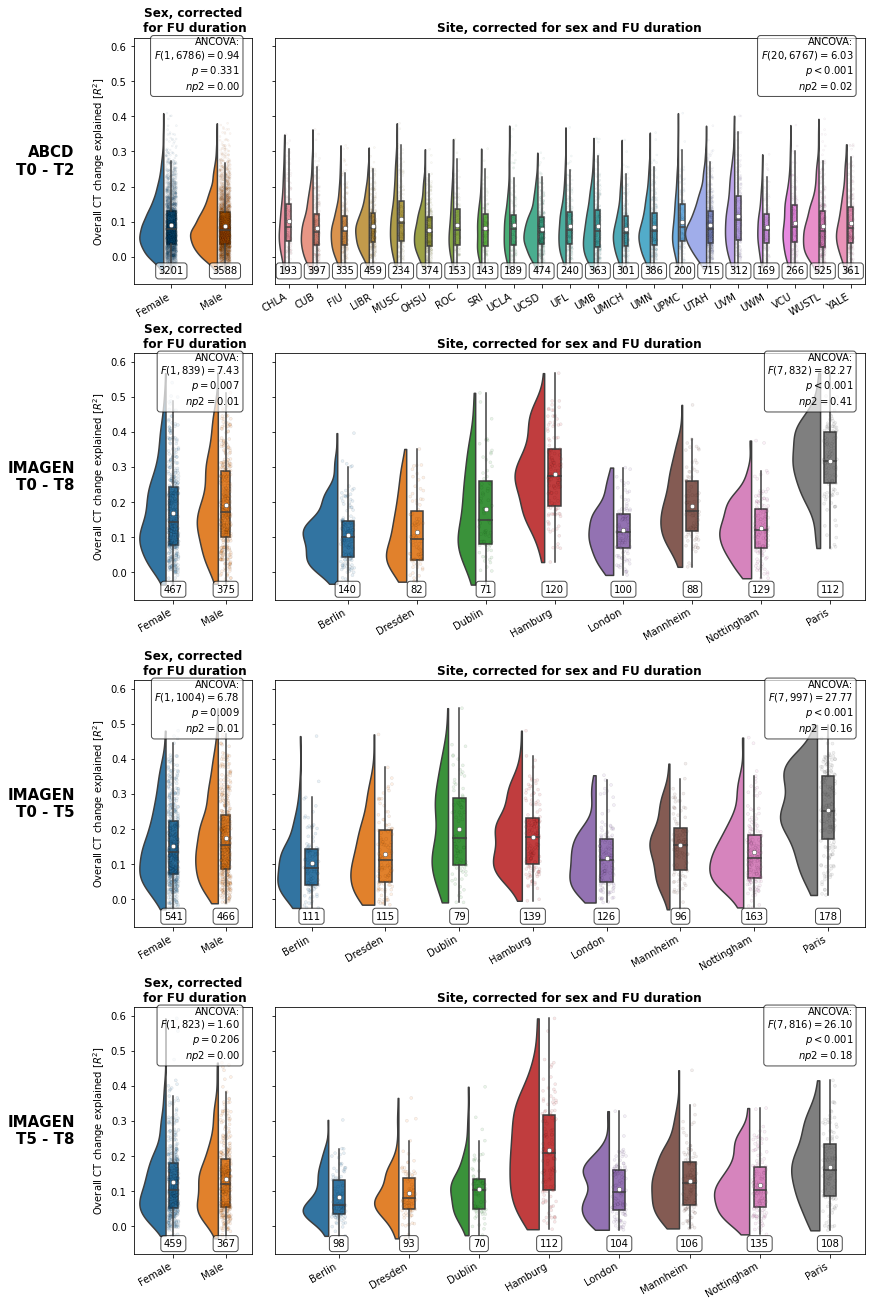

In [32]:
pw_tests = list()

fig, axes = plt.subplots(len(ds_tss), 2, figsize=(12,18), constrained_layout=True,
                         gridspec_kw=dict(width_ratios=(0.4,2)), sharey=True)

for r, (ds, ts) in enumerate(ds_tss):
    df = abcd if ds=="abcd" else imgn
        
    temp = res_delta.loc[(ds, na(), ts, "delta"), ["full_r2"]]
    temp["sex"] = df.loc[(temp.index.get_level_values("id"), ts[:2]), "sex_str"].values
    temp["sex_num"] = df.loc[(temp.index.get_level_values("id"), ts[:2]), "sex"].values
    temp["site"] = df.loc[(temp.index.get_level_values("id"), ts[:2]), "site_str"].values
    temp["age_diff"] = df.loc[(temp.index.get_level_values("id"), ts[2:]), "age"].values - \
        df.loc[(temp.index.get_level_values("id"), ts[:2]), "age"].values
    temp.site = [s.title() for s in temp.site] if ds=="imgn" else temp.site
    temp = temp.melt(["sex", "site", "sex_num", "age_diff"])
    
    temp = temp.replace({
        "M": "Male",
        "F": "Female"
    })
   
    n = temp.groupby("site").count()["value"].sort_index(ascending=True)
    temp.index = pd.Index(temp.site, name="idx")
    idx_ordered = n.index
    temp = temp.loc[idx_ordered.tolist(),]
    
    # plot
    for c, (x_lab, y_lab, order, title) in enumerate(zip(
        ["sex", "site"],
        ["full_r2", "full_r2"],
        [["Female", "Male"], idx_ordered],
        ["Sex, corrected\n for FU duration", "\nSite, corrected for sex and FU duration"]
    )):
        
        plot_raincloud(
            data=temp[temp.variable==y_lab],
            ax=axes[r,c],
            x=x_lab,
            y="value",
            y_mean=temp[temp.variable==y_lab].groupby(x_lab).mean().loc[order, "value"],
            x_mean=range(len(order)),
            violin_scale="count",
            violin_w=1.5 if (ds=="abcd") & (x_lab!="sex") else 1,
            violinbox_lw=1.5,
            scatter_a=0.05 if ds=="abcd" else 0.1,
            scatter_s=2 if ds=="abcd" else 3,
            scatter_lw=0.5,
            mean_s=20
        )
        
        axes[r,c].set_title(title, weight="semibold")
        if c==0:
            axes[r,c].set_ylabel("Overall CT change explained [$R^2$]")
            # dataset & timespan
            axes[r,c].annotate(
                f"{'ABCD' if ds=='abcd' else 'IMAGEN'}\n"
                f"{ts[:2]} - {ts[2:]}",
                xy=(-0.5,0.5), xycoords="axes fraction", 
                weight="semibold", size=15, va="center", ha="right"
            )
        
        # sample size
        n_sub = temp[temp.variable==y_lab].groupby(x_lab).count().loc[order, "value"]
        for i, lab in enumerate(order):
            axes[r,c].text(
                s=f"{n_sub[i]}",
                y=axes[r,c].get_ylim()[0] + 0.02,
                x=i,
                ha="center",
                bbox=dict(boxstyle="round", facecolor='w', alpha=0.7)
            )
                
        anc = ancova(
            data=temp[temp.variable==y_lab],
            dv="value",
            between=x_lab,
            covar=["age_diff"] if ds=="abcd" else ["sex_num", "age_diff"] 
        )
        p = anc['p-unc'].values[0]
        s = "ANCOVA:\n" \
            f"$F({anc.DF.values[0]},{anc.DF.values[-1]}) = {anc.F.values[0]:.02f}$\n " \
            f"$p{'<0.001' if p < 0.001 else '='+str(p.round(3))}$\n " \
            f"$np2={anc.np2.values[0]:.02f}$"
                
        axes[r,c].text(
            s=s,
            y=0.79,
            x=0.9 if x_lab=="sex" else 0.98,
            ha="right",
            bbox=dict(boxstyle="round", facecolor='w', alpha=0.7),
            transform=axes[r,c].transAxes
        )
        
        # pairwise table
        if (x_lab!="sex") & (p < 0.05):
            
            pw = pairwise_tests(
                data=temp[temp.variable==y_lab],
                dv="value",
                between=x_lab,
                padjust="fdr_bh"
            )

            pw = pw.rename(columns={
                "A": "Group A",
                "B": "Group B",
                "dof": "df",
                "p-corr": "p-FDR",
                "hedges": "g"
            })
            pw = pw[["Group A", "Group B", "T", "df", "p-FDR", "g"]]
            pw[["T", "df", "g"]] = pw[["T", "df", "g"]].round(2)
            pw["p-FDR"] = ["< 0.001" if p < 0.001 else f"{p:.03f}" for p in pw["p-FDR"]]
            pw_tests.append(pw)
            print(pw)

        
_ = [ax.set_xticklabels(ax.get_xticklabels(), ha="right", rotation=30) for ax in axes.ravel()]

plt.savefig(join(plot_dir, f"dev_sex_site.png"), bbox_inches="tight", dpi=400)